In [1]:
# =========================
# CELL 0  Clean start + Seeds + Device
# =========================
import os, random, gc, json, math, time
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # change if needed

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()


CUDA: True | device: cuda
GPU: NVIDIA RTX A6000


In [2]:
# =========================
# CELL 1  Imports + Load manifest (SHHS1 only)
# =========================
import re
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from collections import Counter

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, average_precision_score

ROOT = Path("/data2/Akbar1/sleep_stages_Dibatic/shhs_sleepstaging_planA/")
MANIFEST_PATH = ROOT / "manifest_sleepstaging_planA.csv"

manifest = pd.read_csv(MANIFEST_PATH)
print("Manifest rows:", len(manifest))
print(manifest.groupby(["cohort","split"]).size())

df_shhs1 = manifest[manifest.cohort == "SHHS1"].copy()
print("SHHS1 rows:", len(df_shhs1))
print(df_shhs1["split"].value_counts(dropna=False))


Manifest rows: 9868
cohort  split        
MESA    external_test    1856
SHHS1   test              548
        train            4380
        val               548
SHHS2   external_test    2536
dtype: int64
SHHS1 rows: 5476
train    4380
val       548
test      548
Name: split, dtype: int64


In [3]:
# =========================
# CELL 2  Subject ID utilities + Make SHHS1 train/val/test (subject-safe)
# =========================
def infer_subject_id_from_path(npz_path: str):
    stem = Path(npz_path).stem
    stem = re.sub(r"_inhouse$", "", stem)
    return stem

def ensure_subject_id(df):
    df = df.copy()
    if "subject_id" not in df.columns:
        df["subject_id"] = df["npz_path"].astype(str).apply(infer_subject_id_from_path)
    return df

df_shhs1 = ensure_subject_id(df_shhs1)
print("Unique subjects (SHHS1):", df_shhs1["subject_id"].nunique())

# Use manifest split (train/val/test), but enforce NO subject overlap across splits
df_train0 = df_shhs1[df_shhs1["split"]=="train"].copy()
df_val0   = df_shhs1[df_shhs1["split"]=="val"].copy()
df_test0  = df_shhs1[df_shhs1["split"]=="test"].copy()

train_subj = set(df_train0.subject_id.unique())
val_subj   = set(df_val0.subject_id.unique())
test_subj  = set(df_test0.subject_id.unique())

# Remove overlaps in priority order: train > val > test
val_subj = val_subj - train_subj
test_subj = test_subj - train_subj - val_subj

df_train = df_train0[df_train0.subject_id.isin(train_subj)].reset_index(drop=True)
df_val   = df_val0[df_val0.subject_id.isin(val_subj)].reset_index(drop=True)
df_test  = df_test0[df_test0.subject_id.isin(test_subj)].reset_index(drop=True)

print("Final subject counts:",
      "train", df_train.subject_id.nunique(),
      "val", df_val.subject_id.nunique(),
      "test", df_test.subject_id.nunique())

assert set(df_train.subject_id).isdisjoint(set(df_val.subject_id))
assert set(df_train.subject_id).isdisjoint(set(df_test.subject_id))
assert set(df_val.subject_id).isdisjoint(set(df_test.subject_id))


Unique subjects (SHHS1): 5476
Final subject counts: train 4380 val 548 test 548


In [4]:
# =========================
# CELL 3  Augmentation + normalization
# =========================
FS = 125
T = 3750          # 30s * 125 Hz
NUM_CLASSES = 5
LABELS = {0:"W", 1:"N1", 2:"N2", 3:"N3", 4:"REM"}

class EEGAugment:
    def __init__(self,
                 p_amp=0.5, p_noise=0.5, p_shift=0.5,
                 p_bandstop=0.3, p_freqdrop=0.3,
                 amp_range=(0.8, 1.2),
                 noise_std=0.01,
                 shift_max=125,
                 bandstop_ranges=((49,51), (59,61)),
                 freqdrop_max_bins=12):
        self.p_amp = p_amp
        self.p_noise = p_noise
        self.p_shift = p_shift
        self.p_bandstop = p_bandstop
        self.p_freqdrop = p_freqdrop
        self.amp_range = amp_range
        self.noise_std = noise_std
        self.shift_max = shift_max
        self.bandstop_ranges = bandstop_ranges
        self.freqdrop_max_bins = freqdrop_max_bins

    def _amp_scale(self, x):
        s = np.random.uniform(self.amp_range[0], self.amp_range[1])
        return x * s

    def _gaussian_noise(self, x):
        std = np.std(x, axis=1, keepdims=True) + 1e-6
        noise = np.random.randn(*x.shape).astype(np.float32) * (self.noise_std * std)
        return x + noise

    def _time_shift(self, x):
        shift = np.random.randint(-self.shift_max, self.shift_max+1)
        return np.roll(x, shift=shift, axis=1)

    def _bandstop_fft(self, x, fs=125.0):
        E, T_ = x.shape
        X = np.fft.rfft(x, axis=1)
        freqs = np.fft.rfftfreq(T_, d=1.0/fs)
        for (f1, f2) in self.bandstop_ranges:
            mask = (freqs >= f1) & (freqs <= f2)
            X[:, mask] = 0.0
        y = np.fft.irfft(X, n=T_, axis=1).astype(np.float32)
        return y

    def _freq_dropout(self, x):
        E, T_ = x.shape
        X = np.fft.rfft(x, axis=1)
        Fbins = X.shape[1]
        drop = np.random.randint(1, self.freqdrop_max_bins+1)
        start = np.random.randint(0, max(1, Fbins - drop))
        X[:, start:start+drop] = 0.0
        y = np.fft.irfft(X, n=T_, axis=1).astype(np.float32)
        return y

    def __call__(self, x, fs=125.0):
        if np.random.rand() < self.p_amp:      x = self._amp_scale(x)
        if np.random.rand() < self.p_noise:    x = self._gaussian_noise(x)
        if np.random.rand() < self.p_shift:    x = self._time_shift(x)
        if np.random.rand() < self.p_bandstop: x = self._bandstop_fft(x, fs=fs)
        if np.random.rand() < self.p_freqdrop: x = self._freq_dropout(x)
        return x

def normalize_epochs_zscore(x, eps=1e-6, clip=10.0):
    mu = np.mean(x, axis=1, keepdims=True)
    sd = np.std(x, axis=1, keepdims=True) + eps
    x = (x - mu) / sd
    if clip is not None:
        x = np.clip(x, -clip, clip)
    return x.astype(np.float32)

augment = EEGAugment()
print("Augment + normalize ready.")


Augment + normalize ready.


In [5]:
# =========================
# CELL 4  Dataset + Collate + loaders
# =========================
class SleepSequenceDataset(Dataset):
    """
    One item = one subject recording.
    Returns:
      x: (L,1,T) float32
      y: (L,)   int64
      mask: (L,) bool
    """
    def __init__(self, df, mode="train",
                 max_hours=None, min_hours=2.0,
                 augmentor=None,
                 exclude_unknown=True,
                 do_normalize=True,
                 boundary_oversample_p=0.70,
                 boundary_radius=2):
        self.paths = df["npz_path"].tolist()
        self.mode = mode
        self.max_hours = max_hours
        self.min_hours = min_hours
        self.augmentor = augmentor
        self.exclude_unknown = exclude_unknown
        self.do_normalize = do_normalize
        self.boundary_oversample_p = float(boundary_oversample_p)
        self.boundary_radius = int(boundary_radius)

    def __len__(self):
        return len(self.paths)

    def _pick_block_start_boundary_aware(self, y, L):
        E = len(y)
        if E <= L:
            return 0
        if np.random.rand() > self.boundary_oversample_p:
            return np.random.randint(0, E - L + 1)

        trans = np.where(y[1:] != y[:-1])[0] + 1
        if trans.size == 0:
            return np.random.randint(0, E - L + 1)

        t = int(np.random.choice(trans))
        start = t - (L // 2)
        start = max(0, min(start, E - L))
        return int(start)

    def __getitem__(self, idx):
        p = self.paths[idx]
        d = np.load(p, allow_pickle=True)
        x = d["x"].astype(np.float32)    # (E,T)
        y = d["y"].astype(np.int64)      # (E,)

        if self.exclude_unknown:
            keep = (y >= 0)
            x = x[keep]
            y = y[keep]

        if self.do_normalize:
            x = normalize_epochs_zscore(x, eps=1e-6, clip=10.0)

        E = len(y)

        if self.max_hours is not None:
            max_L = int((self.max_hours * 3600) / 30)
            min_L = int((self.min_hours * 3600) / 30)

            L = min(max_L, E)
            if E > L:
                start = self._pick_block_start_boundary_aware(y, L)
                x = x[start:start+L]
                y = y[start:start+L]
                E = L

        if self.mode == "train" and self.augmentor is not None:
            x = self.augmentor(x, fs=FS)

        x_t = torch.from_numpy(x).unsqueeze(1)  # (E,1,T)
        y_t = torch.from_numpy(y).long()        # (E,)
        m_t = torch.ones((E,), dtype=torch.bool)
        return x_t, y_t, m_t

def collate_pad(batch):
    lengths = [b[0].shape[0] for b in batch]
    Lmax = max(lengths)
    xs, ys, ms = [], [], []
    for x, y, m in batch:
        L = x.shape[0]
        padL = Lmax - L
        if padL > 0:
            x = torch.cat([x, torch.zeros((padL,1,T), dtype=x.dtype)], dim=0)
            y = torch.cat([y, torch.zeros((padL,), dtype=y.dtype)], dim=0)
            m = torch.cat([m, torch.zeros((padL,), dtype=torch.bool)], dim=0)
        xs.append(x); ys.append(y); ms.append(m)
    return torch.stack(xs,0), torch.stack(ys,0), torch.stack(ms,0)

BATCH_SUBJ = 2
NUM_WORKERS = 2
PIN = True

def make_loader_from_df(df, mode, batch_size, shuffle, augmentor):
    ds = SleepSequenceDataset(
        df, mode=mode,
        max_hours=4.0 if mode=="train" else None,
        min_hours=2.0,
        augmentor=augmentor if mode=="train" else None,
        exclude_unknown=True,
        do_normalize=True,
        boundary_oversample_p=0.70,
        boundary_radius=2
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS if mode=="train" else 1,
        pin_memory=PIN,
        collate_fn=collate_pad,
        persistent_workers=False
    )

train_loader = make_loader_from_df(df_train, "train", BATCH_SUBJ, True, augment)
val_loader   = make_loader_from_df(df_val,   "eval",  1, False, None)
test_loader  = make_loader_from_df(df_test,  "eval",  1, False, None)

print("Loaders ready:", len(train_loader), len(val_loader), len(test_loader))


Loaders ready: 2190 548 548


In [6]:
# =========================
# CELL 5  Model (V4) + MINIMAL interpretability hook for attention
# =========================
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        if (not self.training) or self.drop_prob == 0.0:
            return x
        keep = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        rand = keep + torch.rand(shape, device=x.device)
        mask = torch.floor(rand)
        return x / keep * mask

class ResConv1D(nn.Module):
    def __init__(self, c_in, c_out, k, s=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(c_in, c_out, k, stride=s, padding=k//2),
            nn.BatchNorm1d(c_out),
            nn.GELU(),
            nn.Conv1d(c_out, c_out, k, padding=k//2),
            nn.BatchNorm1d(c_out),
        )
        self.skip = nn.Conv1d(c_in, c_out, 1, stride=s) if (c_in != c_out or s != 1) else nn.Identity()
        self.act = nn.GELU()

    def forward(self, x):
        return self.act(self.conv(x) + self.skip(x))

class EpochEncoder(nn.Module):
    """
    Input : (B,L,1,T)
    Output: (B,L,384)
    """
    def __init__(self, d_model=384):
        super().__init__()
        self.branch_short = ResConv1D(1, 128, k=7,  s=4)
        self.branch_mid   = ResConv1D(1, 128, k=15, s=4)
        self.branch_long  = ResConv1D(1, 128, k=31, s=4)

        self.freq_proj = nn.Sequential(
            nn.Linear(1876, 256),
            nn.LayerNorm(256),
            nn.GELU(),
        )

        self.fuse = nn.Sequential(
            nn.Linear(128*3 + 256, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
        )

    def forward(self, x):
        B, L, _, T_ = x.shape
        x = x.view(B*L, 1, T_)

        zs = self.branch_short(x).mean(-1)
        zm = self.branch_mid(x).mean(-1)
        zl = self.branch_long(x).mean(-1)

        with torch.cuda.amp.autocast(enabled=False):
            xf32 = x.squeeze(1).float()
            Xf = torch.fft.rfft(xf32, dim=-1)
            mag = torch.abs(Xf)[:, :1876]
            mag = torch.log1p(mag)
            mag = mag / (mag.mean(dim=1, keepdim=True) + 1e-6)

        zf = self.freq_proj(mag)
        z = torch.cat([zs, zm, zl, zf.to(zs.dtype)], dim=-1)
        z = self.fuse(z)
        return z.view(B, L, -1)

def rotate_half(x):
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    return torch.stack((-x2, x1), dim=-1).flatten(-2)

class RoPE(nn.Module):
    def __init__(self, head_dim, base=10000):
        super().__init__()
        assert head_dim % 2 == 0
        self.head_dim = head_dim
        self.base = base

    def forward(self, x):
        B, L, H, Dh = x.shape
        half = Dh // 2
        freqs = 1.0 / (self.base ** (torch.arange(half, device=x.device) / half))
        t = torch.arange(L, device=x.device)
        angles = torch.einsum("l,d->ld", t, freqs)
        cos = torch.cos(angles)[None, :, None, :]
        sin = torch.sin(angles)[None, :, None, :]
        cos = cos.repeat_interleave(2, dim=-1)
        sin = sin.repeat_interleave(2, dim=-1)
        return (x * cos) + (rotate_half(x) * sin)

class MultiHeadSelfAttentionRoPE(nn.Module):
    def __init__(self, d_model=384, n_heads=8, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3*d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.rope = RoPE(self.d_head)

        # ---- interpretability hook (minimal)
        self.last_attn = None  # will store (B,H,L,L) attention probs during forward

    def forward(self, x, key_padding_mask=None, record_attn=False):
        B, L, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        q = q.view(B, L, self.n_heads, self.d_head)
        k = k.view(B, L, self.n_heads, self.d_head)
        v = v.view(B, L, self.n_heads, self.d_head)

        q = self.rope(q)
        k = self.rope(k)

        q = q.transpose(1, 2)  # (B,H,L,Dh)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)
        scores = scores.float()
        if key_padding_mask is not None:
            scores = scores.masked_fill(~key_padding_mask[:, None, None, :], -1e9)

        attn = torch.softmax(scores, dim=-1)
        attn = self.drop(attn).to(v.dtype)

        if record_attn:
            self.last_attn = attn.detach().float().cpu()  # store safely

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.proj(out)

class TransformerBlock(nn.Module):
    def __init__(self, d_model=384, n_heads=8, drop=0.1, drop_path=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttentionRoPE(d_model, n_heads, drop)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(4*d_model, d_model),
        )
        self.dp = DropPath(drop_path)

    def forward(self, x, mask, record_attn=False):
        x = x + self.dp(self.attn(self.ln1(x), mask, record_attn=record_attn))
        x = x + self.dp(self.mlp(self.ln2(x)))
        return x

class HierSleepTransformerV4(nn.Module):
    def __init__(self, num_classes=5, d_model=384, depth=10, n_heads=8):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = EpochEncoder(d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, drop_path=0.1*(i+1)/depth)
            for i in range(depth)
        ])
        self.head = nn.Linear(d_model, num_classes)
        self.aux_n1 = nn.Linear(d_model, 2)
        self.trans_logits = nn.Parameter(torch.zeros(num_classes, num_classes))

    def forward(self, x, mask, record_attn=False):
        z = self.encoder(x)
        for blk in self.blocks:
            z = blk(z, mask, record_attn=record_attn)
        main_logits = self.head(z)     # (B,L,C)
        aux_logits  = self.aux_n1(z)   # (B,L,2)
        return main_logits, aux_logits

tmp = HierSleepTransformerV4(NUM_CLASSES, 384, 10, 8).to(device)
print("Params (M):", sum(p.numel() for p in tmp.parameters())/1e6)
del tmp


Params (M): 19.353504


In [7]:
# =========================
# CELL 6  Loss + EMA + eval (same as you use)
# =========================
USE_EMA = True
EMA_DECAY = 0.999

USE_AUX_N1 = True
AUX_N1_WEIGHT = 0.30

USE_LA_CE = True
LA_TAU = 1.0

USE_HARD_NEG_N1 = True
HARD_NEG_MULT = 2.0

USE_TRANS_LOSS = True
TRANS_LOSS_WEIGHT = 0.10

USE_LEARNED_SMOOTHING = True

smooth_vec = torch.tensor([0.02, 0.00, 0.05, 0.05, 0.02], dtype=torch.float32).to(device)

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = float(decay)
        self.shadow = {n: p.data.detach().clone() for n,p in model.named_parameters() if p.requires_grad}

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if name in self.shadow:
                self.shadow[name].mul_(self.decay)
                self.shadow[name].add_((1.0 - self.decay) * p.data)

    def apply(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if name in self.shadow:
                self.backup[name] = p.data.detach().clone()
                p.data.copy_(self.shadow[name])

    def restore(self, model):
        for name, p in model.named_parameters():
            if name in self.backup:
                p.data.copy_(self.backup[name])

class LogitAdjustedCE(nn.Module):
    def __init__(self, class_freq, tau=1.0):
        super().__init__()
        freq = torch.tensor(class_freq, dtype=torch.float32)
        self.register_buffer("log_prior", torch.log(freq / freq.sum()))
        self.tau = float(tau)

    def forward(self, logits, targets, reduction="none"):
        logits = logits + self.tau * self.log_prior
        return F.cross_entropy(logits, targets, reduction=reduction)

def label_smoothing_nll(logits, targets, smooth_per_class):
    logp = F.log_softmax(logits, dim=-1)
    nll = -logp.gather(dim=-1, index=targets.view(-1,1)).squeeze(1)
    smooth = -logp.mean(dim=-1)
    s = smooth_per_class[targets]
    return (1 - s) * nll + s * smooth

def compute_transition_loss(model, y, mask):
    B, L = y.shape
    y_prev = y[:, :-1]
    y_next = y[:, 1:]
    m_pair = mask[:, :-1] & mask[:, 1:]
    if m_pair.sum().item() == 0:
        return torch.zeros((), device=y.device)
    y_prev_v = y_prev[m_pair]
    y_next_v = y_next[m_pair]
    logits_pair = model.trans_logits[y_prev_v]
    return F.cross_entropy(logits_pair, y_next_v)

def apply_learned_smoothing_probs(probs, model):
    Tm = torch.softmax(model.trans_logits, dim=1)
    return probs @ Tm

def class_counts_train(df):
    c = Counter()
    for p in tqdm(df["npz_path"].tolist(), desc="Counting labels", leave=False):
        d = np.load(p, allow_pickle=True)
        y = d["y"].astype(np.int64)
        y = y[y >= 0]
        c.update(y.tolist())
    return np.array([c.get(i, 0) for i in range(NUM_CLASSES)], dtype=np.float64)

# set after we compute counts on train
la_ce = None

def masked_loss_v4(model, main_logits, aux_logits, y, mask):
    B, L, C = main_logits.shape
    logits2 = main_logits.view(B*L, C)
    y2 = y.view(B*L)
    m2 = mask.view(B*L)

    logits_valid = logits2[m2]
    y_valid = y2[m2]

    if USE_LA_CE:
        adj_logits = logits_valid + la_ce.tau * la_ce.log_prior
        loss_main_vec = label_smoothing_nll(adj_logits, y_valid, smooth_vec)
    else:
        loss_main_vec = label_smoothing_nll(logits_valid, y_valid, smooth_vec)

    if USE_HARD_NEG_N1:
        with torch.no_grad():
            pred = torch.argmax(logits_valid, dim=-1)
            hard = (y_valid == 1) & ((pred == 0) | (pred == 2))
        loss_main_vec = loss_main_vec * torch.where(
            hard,
            torch.tensor(HARD_NEG_MULT, device=device),
            torch.tensor(1.0, device=device)
        )

    loss = loss_main_vec.mean()

    if USE_AUX_N1:
        aux2 = aux_logits.view(B*L, 2)[m2]
        y_aux = (y_valid == 1).long()
        loss_aux = F.cross_entropy(aux2, y_aux)
        loss = loss + AUX_N1_WEIGHT * loss_aux

    if USE_TRANS_LOSS:
        loss_trans = compute_transition_loss(model, y, mask)
        loss = loss + TRANS_LOSS_WEIGHT * loss_trans

    return loss

def _ece_from_probs(y_true, probs, n_bins=15):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    acc = (pred == y_true).astype(np.float32)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (conf >= lo) & (conf < hi)
        if m.sum() == 0:
            continue
        ece += (m.mean()) * abs(acc[m].mean() - conf[m].mean())
    return float(ece)

def _auroc_auprc_multiclass(y_true, probs, num_classes=5):
    Y = label_binarize(y_true, classes=list(range(num_classes)))
    aurocs, auprcs = [], []
    for c in range(num_classes):
        if Y[:, c].sum() == 0:
            continue
        try:
            aurocs.append(roc_auc_score(Y[:, c], probs[:, c]))
            auprcs.append(average_precision_score(Y[:, c], probs[:, c]))
        except Exception:
            pass
    if len(aurocs) == 0:
        return float("nan"), float("nan")
    return float(np.mean(aurocs)), float(np.mean(auprcs))

@torch.no_grad()
def eval_sequence(model, loader, desc="Eval", record_attn=False):
    model.eval()
    all_true, all_pred, all_probs = [], [], []
    total_loss, total_n = 0.0, 0

    for xb, yb, mb in tqdm(loader, desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            main_logits, aux_logits = model(xb, mb, record_attn=record_attn)
            loss = masked_loss_v4(model, main_logits, aux_logits, yb, mb)

        probs = torch.softmax(main_logits.float(), dim=-1)
        if USE_LEARNED_SMOOTHING:
            probs = apply_learned_smoothing_probs(probs, model)

        pred = torch.argmax(probs, dim=-1)

        yv = yb[mb].detach().cpu().numpy()
        pv = pred[mb].detach().cpu().numpy()
        pr = probs[mb].detach().cpu().numpy()

        if yv.size == 0:
            continue

        all_true.append(yv); all_pred.append(pv); all_probs.append(pr)

        n = int(mb.sum().item())
        total_loss += float(loss.item()) * n
        total_n += n

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    probs_all = np.concatenate(all_probs)

    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

    auroc, auprc = _auroc_auprc_multiclass(y_true, probs_all, num_classes=NUM_CLASSES)
    mean_conf = float(probs_all.max(axis=1).mean())
    ece = _ece_from_probs(y_true, probs_all, n_bins=15)

    f1_per = {LABELS[i]: float(f1_score((y_true==i).astype(int), (y_pred==i).astype(int))) for i in range(NUM_CLASSES)}

    return {
        "loss": total_loss / max(total_n, 1),
        "acc": float(acc),
        "macro_f1": float(mf1),
        "kappa": float(kappa),
        "AUROC": float(auroc),
        "AUPRC": float(auprc),
        "meanConf": mean_conf,
        "ECE": ece,
        "f1_per_class": f1_per,
        "cm": cm,
    }


In [8]:
# =========================
# CELL 7  Train SHHS1 (train/val/test) + Save best checkpoint + metrics
# =========================
RUN_DIR = Path("./runs_interpretability_shhs1") / time.strftime("%Y%m%d_%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

EPOCHS = 60
LR = 2e-4
MAX_LR = 5e-4

# fold-safe LA prior on TRAIN only
counts_train = class_counts_train(df_train)
la_ce = LogitAdjustedCE(class_freq=counts_train, tau=LA_TAU).to(device)

gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()

model = HierSleepTransformerV4(NUM_CLASSES, 384, 10, 8).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.15,
    div_factor=20.0,
    final_div_factor=100.0
)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
ema = EMA(model, EMA_DECAY) if USE_EMA else None

best_val = -1.0
best_state = None
history = []

for epoch in range(1, EPOCHS+1):
    model.train()

    # droppath warmup
    warm = min(1.0, epoch / 10.0)
    for blk in model.blocks:
        blk.dp.drop_prob = 0.10 * warm

    running_loss, n_seen = 0.0, 0

    for xb, yb, mb in tqdm(train_loader, desc=f"Train ep{epoch}", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            main_logits, aux_logits = model(xb, mb)
            loss = masked_loss_v4(model, main_logits, aux_logits, yb, mb)

        if not torch.isfinite(loss):
            continue

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if ema is not None:
            ema.update(model)

        n = int(mb.sum().item())
        running_loss += float(loss.item()) * max(n,1)
        n_seen += max(n,1)

    train_loss = running_loss / max(n_seen, 1)

    # VAL with EMA weights
    if ema is not None:
        ema.apply(model)
    val_m = eval_sequence(model, val_loader, desc=f"VAL ep{epoch}")
    if ema is not None:
        ema.restore(model)

    row = {"epoch": epoch, "train_loss": train_loss, **{f"val_{k}": v for k,v in val_m.items() if k!="cm"}}
    history.append(row)

    print(f"[Ep {epoch:02d}] train_loss={train_loss:.4f} | VAL macroF1={val_m['macro_f1']:.4f} acc={val_m['acc']:.4f}")

    if float(val_m["macro_f1"]) > best_val:
        best_val = float(val_m["macro_f1"])
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        ckpt = {
            "epoch": epoch,
            "best_val_macroF1": best_val,
            "model_state": best_state,
            "counts_train": counts_train,
            "config": {
                "EPOCHS": EPOCHS,
                "LR": LR,
                "MAX_LR": MAX_LR,
                "SEED": SEED,
                "USE_EMA": USE_EMA,
                "EMA_DECAY": EMA_DECAY
            }
        }
        torch.save(ckpt, RUN_DIR / "best.pt")
        with open(RUN_DIR / "best_meta.json", "w") as f:
            json.dump({"epoch": epoch, "best_val_macroF1": best_val}, f, indent=2)

# Save training log
pd.DataFrame(history).to_csv(RUN_DIR / "train_history.csv", index=False)
print("Saved:", RUN_DIR / "best.pt", "and train_history.csv")


RUN_DIR: runs_interpretability_shhs1/20260110_013004


Train ep1:   0%|                                       | 0/2190 [00:00<?, ?it/s]/usr/local/anaconda3/envs/akbar1/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[Ep 01] train_loss=0.9264 | VAL macroF1=0.6256 acc=0.7814


[Ep 02] train_loss=0.7937 | VAL macroF1=0.7348 acc=0.8276


[Ep 03] train_loss=0.7620 | VAL macroF1=0.7679 acc=0.8354


[Ep 04] train_loss=0.7288 | VAL macroF1=0.7745 acc=0.8393


[Ep 05] train_loss=0.7063 | VAL macroF1=0.7836 acc=0.8415


[Ep 06] train_loss=0.6845 | VAL macroF1=0.7839 acc=0.8395


[Ep 07] train_loss=0.6747 | VAL macroF1=0.7820 acc=0.8369


[Ep 08] train_loss=0.6680 | VAL macroF1=0.7857 acc=0.8412


[Ep 09] train_loss=0.6635 | VAL macroF1=0.7833 acc=0.8387


[Ep 10] train_loss=0.6553 | VAL macroF1=0.7859 acc=0.8430


[Ep 11] train_loss=0.6438 | VAL macroF1=0.7872 acc=0.8419


[Ep 12] train_loss=0.6364 | VAL macroF1=0.7898 acc=0.8472


[Ep 13] train_loss=0.6318 | VAL macroF1=0.7901 acc=0.8453


[Ep 14] train_loss=0.6262 | VAL macroF1=0.7927 acc=0.8483


[Ep 15] train_loss=0.6214 | VAL macroF1=0.7920 acc=0.8469


[Ep 16] train_loss=0.6181 | VAL macroF1=0.7959 acc=0.8528


[Ep 17] train_loss=0.6149 | VAL macroF1=0.7927 acc=0.8486


[Ep 18] train_loss=0.6089 | VAL macroF1=0.7962 acc=0.8518


[Ep 19] train_loss=0.6080 | VAL macroF1=0.7904 acc=0.8452


[Ep 20] train_loss=0.6020 | VAL macroF1=0.7964 acc=0.8521


[Ep 21] train_loss=0.6003 | VAL macroF1=0.7962 acc=0.8512


[Ep 22] train_loss=0.5972 | VAL macroF1=0.7941 acc=0.8486


[Ep 23] train_loss=0.5953 | VAL macroF1=0.7954 acc=0.8501


[Ep 24] train_loss=0.5914 | VAL macroF1=0.7974 acc=0.8527


[Ep 25] train_loss=0.5880 | VAL macroF1=0.7970 acc=0.8523


[Ep 26] train_loss=0.5833 | VAL macroF1=0.7976 acc=0.8526


[Ep 27] train_loss=0.5807 | VAL macroF1=0.7990 acc=0.8544


[Ep 28] train_loss=0.5777 | VAL macroF1=0.7994 acc=0.8549


[Ep 29] train_loss=0.5774 | VAL macroF1=0.8008 acc=0.8560


[Ep 30] train_loss=0.5706 | VAL macroF1=0.8005 acc=0.8557


[Ep 31] train_loss=0.5700 | VAL macroF1=0.7984 acc=0.8533


[Ep 32] train_loss=0.5685 | VAL macroF1=0.8010 acc=0.8567


[Ep 33] train_loss=0.5653 | VAL macroF1=0.8002 acc=0.8551


[Ep 34] train_loss=0.5612 | VAL macroF1=0.7999 acc=0.8548


[Ep 35] train_loss=0.5567 | VAL macroF1=0.7994 acc=0.8542


[Ep 36] train_loss=0.5540 | VAL macroF1=0.8011 acc=0.8562


[Ep 37] train_loss=0.5483 | VAL macroF1=0.8012 acc=0.8570


[Ep 38] train_loss=0.5506 | VAL macroF1=0.8010 acc=0.8559


[Ep 39] train_loss=0.5456 | VAL macroF1=0.8003 acc=0.8557


[Ep 40] train_loss=0.5425 | VAL macroF1=0.8004 acc=0.8557


[Ep 41] train_loss=0.5391 | VAL macroF1=0.8011 acc=0.8563


[Ep 42] train_loss=0.5337 | VAL macroF1=0.8021 acc=0.8583


[Ep 43] train_loss=0.5312 | VAL macroF1=0.8018 acc=0.8579


[Ep 44] train_loss=0.5283 | VAL macroF1=0.8010 acc=0.8571


[Ep 45] train_loss=0.5261 | VAL macroF1=0.8013 acc=0.8576


[Ep 46] train_loss=0.5235 | VAL macroF1=0.8004 acc=0.8570


[Ep 47] train_loss=0.5177 | VAL macroF1=0.8004 acc=0.8570


[Ep 48] train_loss=0.5129 | VAL macroF1=0.8005 acc=0.8569


[Ep 49] train_loss=0.5111 | VAL macroF1=0.8000 acc=0.8567


[Ep 50] train_loss=0.5112 | VAL macroF1=0.7999 acc=0.8566


[Ep 51] train_loss=0.5079 | VAL macroF1=0.8000 acc=0.8570


[Ep 52] train_loss=0.5042 | VAL macroF1=0.8001 acc=0.8568


[Ep 53] train_loss=0.5022 | VAL macroF1=0.7991 acc=0.8561


[Ep 54] train_loss=0.5014 | VAL macroF1=0.7990 acc=0.8559


[Ep 55] train_loss=0.5006 | VAL macroF1=0.7991 acc=0.8560


[Ep 56] train_loss=0.4997 | VAL macroF1=0.7991 acc=0.8562


[Ep 57] train_loss=0.4971 | VAL macroF1=0.7990 acc=0.8559


[Ep 58] train_loss=0.4971 | VAL macroF1=0.7993 acc=0.8562


[Ep 59] train_loss=0.4988 | VAL macroF1=0.7999 acc=0.8568


[Ep 60] train_loss=0.4975 | VAL macroF1=0.7993 acc=0.8562
Saved: runs_interpretability_shhs1/20260110_013004/best.pt and train_history.csv


In [9]:
# =========================
# CELL 8  Load best + Final TEST metrics + Save summary
# =========================
ckpt = torch.load(RUN_DIR / "best.pt", map_location="cpu")
model.load_state_dict({k: v.to(device) for k, v in ckpt["model_state"].items()})

# rebuild la_ce from saved counts (important for eval consistency)
counts_train = ckpt["counts_train"]
la_ce = LogitAdjustedCE(class_freq=counts_train, tau=LA_TAU).to(device)

test_m = eval_sequence(model, test_loader, desc="TEST best")
print("TEST:", {k: (v if k!="cm" else "CM") for k,v in test_m.items()})

summary = {
    "best_val_macroF1": ckpt["best_val_macroF1"],
    "test": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k,v in test_m.items()},
}
with open(RUN_DIR / "test_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved:", RUN_DIR / "test_summary.json")


TEST: {'loss': 0.543774959704541, 'acc': 0.8631185807656396, 'macro_f1': 0.8078892666722955, 'kappa': 0.8109038069042462, 'AUROC': 0.9717968942400017, 'AUPRC': 0.8609098541060416, 'meanConf': 0.6784908771514893, 'ECE': 0.18462772568321992, 'f1_per_class': {'W': 0.9159139410858765, 'N1': 0.5225479896857989, 'N2': 0.8749826384066226, 'N3': 0.8357909614025643, 'REM': 0.8902108027806159}, 'cm': 'CM'}
Saved: runs_interpretability_shhs1/20260110_013004/test_summary.json


In [10]:
# =========================
# CELL 9  Attention rollout utilities (paper-ready)
# =========================
import matplotlib.pyplot as plt

def get_last_attn_per_block(model):
    """Returns list of attention matrices: each (B,H,L,L) as torch CPU float."""
    mats = []
    for blk in model.blocks:
        A = blk.attn.last_attn
        mats.append(A)
    return mats

def attention_rollout(attn_list, head_fuse="mean"):
    """
    attn_list: list of (B,H,L,L)
    returns: (B,L,L) rollout matrix
    """
    # fuse heads
    fused = []
    for A in attn_list:
        if A is None:
            raise RuntimeError("Attention not recorded. Run forward with record_attn=True.")
        if head_fuse == "mean":
            fused.append(A.mean(dim=1))     # (B,L,L)
        elif head_fuse == "max":
            fused.append(A.max(dim=1).values)
        else:
            raise ValueError("head_fuse must be mean or max")

    # rollout: multiply across layers (with identity residual)
    B, L, _ = fused[0].shape
    I = torch.eye(L).unsqueeze(0).repeat(B,1,1)
    R = I.clone()
    for A in fused:
        A_ = A + I
        A_ = A_ / (A_.sum(dim=-1, keepdim=True) + 1e-9)
        R = torch.bmm(A_, R)
    return R  # (B,L,L)

@torch.no_grad()
def forward_record_attention(model, xb, mb):
    model.eval()
    # clear last_attn
    for blk in model.blocks:
        blk.attn.last_attn = None
    with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
        logits, aux = model(xb, mb, record_attn=True)
    return logits, aux


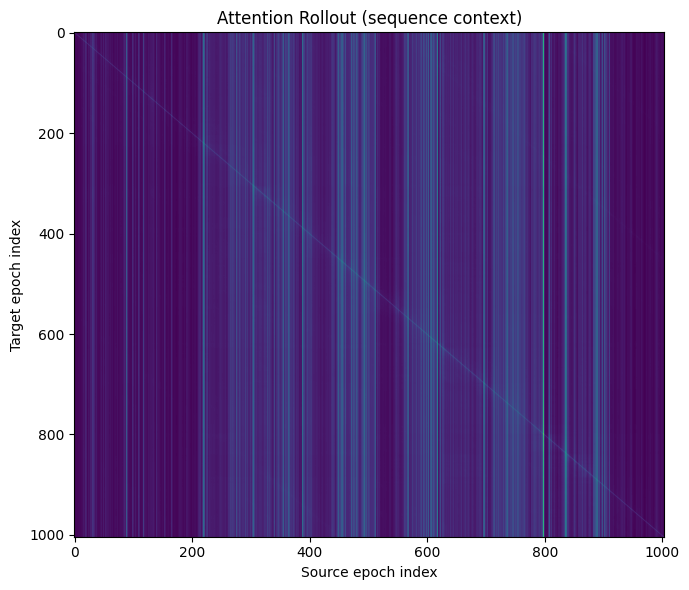

Saved: runs_interpretability_shhs1/20260110_013004/attention_rollout_subject0.png


In [11]:
# =========================
# CELL 10  Run rollout on one TEST subject + Save figure
# =========================
# pick one subject item from test_loader
xb, yb, mb = next(iter(test_loader))
xb = xb.to(device)
yb = yb.to(device)
mb = mb.to(device)

logits, _ = forward_record_attention(model, xb, mb)
probs = torch.softmax(logits.float(), dim=-1)
pred = probs.argmax(dim=-1)

attn_list = get_last_attn_per_block(model)
R = attention_rollout(attn_list, head_fuse="mean")[0].numpy()  # (L,L)

L = int(mb[0].sum().item())
R = R[:L, :L]

plt.figure(figsize=(7,6))
plt.imshow(R, aspect="auto")
plt.title("Attention Rollout (sequence context)")
plt.xlabel("Source epoch index")
plt.ylabel("Target epoch index")
plt.tight_layout()
plt.savefig(RUN_DIR / "attention_rollout_subject0.png", dpi=200)
plt.show()

print("Saved:", RUN_DIR / "attention_rollout_subject0.png")


In [12]:
# =========================
# CELL 11  Integrated Gradients (simple implementation; no Captum needed)
# =========================
def integrated_gradients_epoch(
    model,
    xb, mb,
    target_pos: int,
    target_class: int,
    baseline="zeros",
    steps=50
):
    """
    xb: (1,L,1,T) on device, requires_grad will be set on a copy
    mb: (1,L) bool mask
    target_pos: epoch index in [0,L)
    target_class: class index [0..4]
    Returns:
      attr: (T,) attribution for raw EEG of that epoch
      pred_prob: float
    """
    model.eval()

    x = xb.detach().clone()
    if baseline == "zeros":
        x0 = torch.zeros_like(x)
    elif baseline == "mean":
        x0 = x.mean(dim=-1, keepdim=True).expand_as(x)
    else:
        raise ValueError("baseline must be zeros or mean")

    # only attribute to one epoch position
    # we will integrate over alpha from 0->1
    alphas = torch.linspace(0.0, 1.0, steps, device=xb.device)

    grads_sum = torch.zeros((T,), device=xb.device)

    for a in alphas:
        xi = x0 + a * (x - x0)
        xi.requires_grad_(True)

        logits, _ = model(xi, mb, record_attn=False)
        # focus on that epoch position
        logit = logits[0, target_pos, target_class]
        model.zero_grad(set_to_none=True)
        if xi.grad is not None:
            xi.grad.zero_()
        logit.backward(retain_graph=False)

        g = xi.grad[0, target_pos, 0, :]  # (T,)
        grads_sum += g.detach()

    avg_grads = grads_sum / steps
    attr = (x[0, target_pos, 0, :] - x0[0, target_pos, 0, :]) * avg_grads

    # pred prob for reference
    with torch.no_grad():
        logits, _ = model(xb, mb, record_attn=False)
        prob = torch.softmax(logits.float(), dim=-1)[0, target_pos, target_class].item()

    return attr.detach().cpu().numpy(), float(prob)


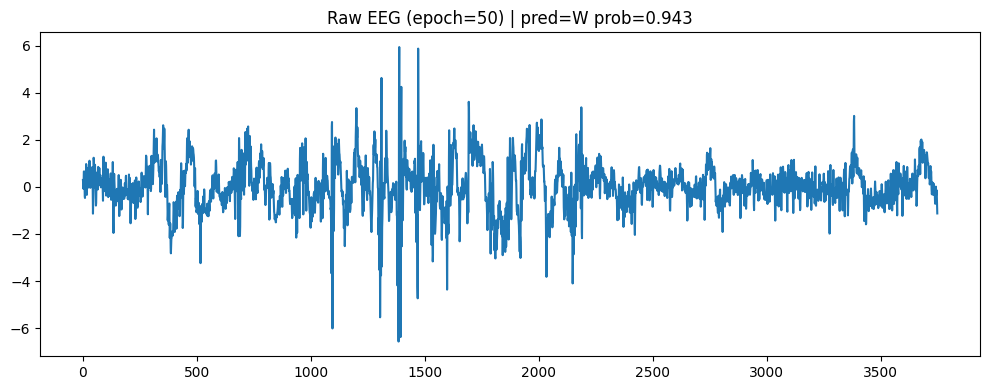

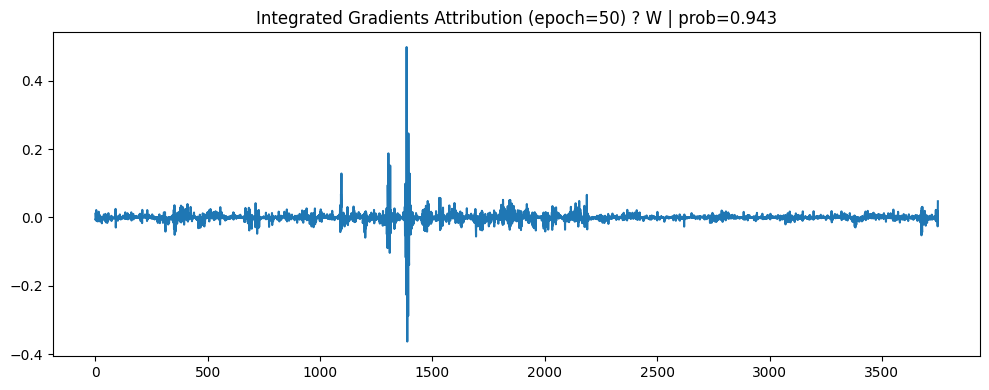

Saved: runs_interpretability_shhs1/20260110_013004/raw_epoch_50.png
Saved: runs_interpretability_shhs1/20260110_013004/ig_epoch_50.png


In [13]:
# =========================
# CELL 12  IG demo plot for one epoch + Save
# =========================
# Use same xb from Cell 10 (one subject)
L = int(mb[0].sum().item())
pos = min(50, L-1)  # choose an epoch index (change as needed)

# predicted class at pos
with torch.no_grad():
    logits0, _ = model(xb, mb)
    probs0 = torch.softmax(logits0.float(), dim=-1)
    pred_class = int(probs0[0, pos].argmax().item())
    pred_prob = float(probs0[0, pos, pred_class].item())

attr, prob = integrated_gradients_epoch(
    model, xb, mb,
    target_pos=pos,
    target_class=pred_class,
    baseline="zeros",
    steps=50
)

raw = xb[0, pos, 0, :].detach().cpu().numpy()

plt.figure(figsize=(10,4))
plt.plot(raw)
plt.title(f"Raw EEG (epoch={pos}) | pred={LABELS[pred_class]} prob={pred_prob:.3f}")
plt.tight_layout()
plt.savefig(RUN_DIR / f"raw_epoch_{pos}.png", dpi=200)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(attr)
plt.title(f"Integrated Gradients Attribution (epoch={pos}) ? {LABELS[pred_class]} | prob={prob:.3f}")
plt.tight_layout()
plt.savefig(RUN_DIR / f"ig_epoch_{pos}.png", dpi=200)
plt.show()

print("Saved:", RUN_DIR / f"raw_epoch_{pos}.png")
print("Saved:", RUN_DIR / f"ig_epoch_{pos}.png")


In [14]:
# =========================
# CELL 13  Band occlusion utilities
# =========================
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 12.0),
    "sigma": (12.0, 16.0),  # spindles
    "beta":  (16.0, 30.0),
}

def bandstop_epoch_numpy(sig_1d, fs, f_lo, f_hi):
    """
    sig_1d: (T,) numpy
    returns band-stopped signal
    """
    X = np.fft.rfft(sig_1d)
    freqs = np.fft.rfftfreq(sig_1d.shape[0], d=1.0/fs)
    mask = (freqs >= f_lo) & (freqs <= f_hi)
    X[mask] = 0.0
    y = np.fft.irfft(X, n=sig_1d.shape[0]).astype(np.float32)
    return y

@torch.no_grad()
def band_occlusion_effect(model, xb, mb, pos, cls, bands=BANDS):
    """
    Returns dict: band -> delta_prob (original_prob - occluded_prob)
    """
    model.eval()
    logits, _ = model(xb, mb)
    p0 = torch.softmax(logits.float(), dim=-1)[0, pos, cls].item()

    effects = {}
    x_np = xb.detach().cpu().numpy()  # (1,L,1,T)
    for name, (flo, fhi) in bands.items():
        x2 = x_np.copy()
        x2[0, pos, 0, :] = bandstop_epoch_numpy(x2[0, pos, 0, :], FS, flo, fhi)
        xb2 = torch.from_numpy(x2).to(device)
        logits2, _ = model(xb2, mb)
        p2 = torch.softmax(logits2.float(), dim=-1)[0, pos, cls].item()
        effects[name] = float(p0 - p2)  # drop in prob
    return float(p0), effects


Epoch: 50 Pred: W Prob: 0.9433085322380066
Band importance (prob drop if removed):
    beta: 0.0175
   sigma: 0.0108
   theta: 0.0039
   delta: 0.0031
   alpha: 0.0013


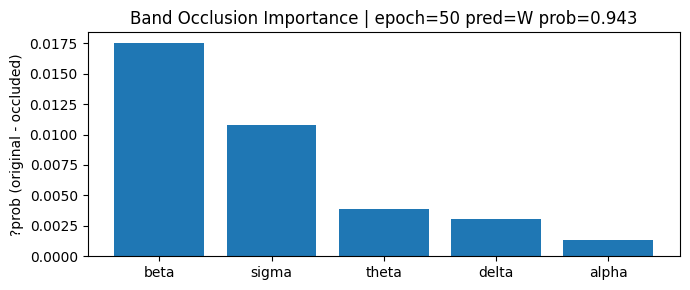

Saved: runs_interpretability_shhs1/20260110_013004/band_occlusion_epoch_50.png
Saved: runs_interpretability_shhs1/20260110_013004/band_occlusion_epoch_50.json


In [15]:
# =========================
# CELL 14  Band occlusion report + Plot + Save
# =========================
pos = min(50, int(mb[0].sum().item())-1)

with torch.no_grad():
    logits0, _ = model(xb, mb)
    probs0 = torch.softmax(logits0.float(), dim=-1)
    cls = int(probs0[0, pos].argmax().item())

p0, effects = band_occlusion_effect(model, xb, mb, pos, cls)
effects_sorted = sorted(effects.items(), key=lambda x: x[1], reverse=True)

print("Epoch:", pos, "Pred:", LABELS[cls], "Prob:", p0)
print("Band importance (prob drop if removed):")
for k,v in effects_sorted:
    print(f"  {k:>6s}: {v:.4f}")

# bar plot
names = [k for k,_ in effects_sorted]
vals = [v for _,v in effects_sorted]

plt.figure(figsize=(7,3))
plt.bar(names, vals)
plt.title(f"Band Occlusion Importance | epoch={pos} pred={LABELS[cls]} prob={p0:.3f}")
plt.ylabel("?prob (original - occluded)")
plt.tight_layout()
plt.savefig(RUN_DIR / f"band_occlusion_epoch_{pos}.png", dpi=200)
plt.show()

# save JSON
with open(RUN_DIR / f"band_occlusion_epoch_{pos}.json", "w") as f:
    json.dump({"epoch": pos, "pred": LABELS[cls], "prob": p0, "effects": effects}, f, indent=2)

print("Saved:", RUN_DIR / f"band_occlusion_epoch_{pos}.png")
print("Saved:", RUN_DIR / f"band_occlusion_epoch_{pos}.json")


In [18]:
# =========================
# CELL 15  Clinical summary generator (per epoch) [FIXED]
#   - Do NOT use @torch.no_grad() because IG needs gradients
# =========================

def topk_attention_sources(rollout_row, k=5):
    idx = np.argsort(-rollout_row)[:k]
    return [(int(i), float(rollout_row[i])) for i in idx]

def ig_peak_window(attr, fs=125, win_sec=2.0):
    w = int(win_sec * fs)
    if w <= 1:
        return (0, 0, float(np.max(np.abs(attr))))
    a = np.abs(attr)
    s = np.convolve(a, np.ones(w), mode="valid")
    start = int(np.argmax(s))
    end = start + w
    return (start, end, float(s[start]))

def clinical_interpret_epoch(model, xb, mb, pos, topk_ctx=5):
    """
    Returns a clinical-friendly dict for one epoch position.
    IMPORTANT: This function MUST allow grad because it calls Integrated Gradients.
    """

    # -------- 1) Prediction + Attention (no grad needed)
    with torch.no_grad():
        logits, _ = forward_record_attention(model, xb, mb)  # records attention
        probs = torch.softmax(logits.float(), dim=-1)
        pred_cls = int(probs[0, pos].argmax().item())
        pred_prob = float(probs[0, pos, pred_cls].item())

        # rollout
        attn_list = get_last_attn_per_block(model)
        R = attention_rollout(attn_list, head_fuse="mean")[0].numpy()
        L = int(mb[0].sum().item())
        row = R[pos, :L]
        ctx = topk_attention_sources(row, k=topk_ctx)

        # band occlusion (no grad)
        _, effects = band_occlusion_effect(model, xb, mb, pos, pred_cls)
        top_bands = sorted(effects.items(), key=lambda x: x[1], reverse=True)[:3]

    # -------- 2) Integrated Gradients (needs grad!)
    # make sure grads are enabled here
    attr, _ = integrated_gradients_epoch(
        model, xb, mb,
        target_pos=pos,
        target_class=pred_cls,
        baseline="zeros",
        steps=40
    )
    w0, w1, score = ig_peak_window(attr, fs=FS, win_sec=2.0)

    return {
        "epoch": int(pos),
        "pred_stage": LABELS[pred_cls],
        "pred_prob": pred_prob,
        "top_context_epochs": ctx,                 # [(epoch_idx, rollout_weight), ...]
        "top_band_importance": top_bands,          # [(band, prob_drop), ...]
        "ig_peak_window_samples": [int(w0), int(w1)],
        "ig_peak_score": float(score),
    }


In [19]:
# =========================
# CELL 16  Generate a full subject clinical report (sample epochs) + Save JSON
# =========================
L = int(mb[0].sum().item())
sample_positions = list(range(0, min(L, 200), 20))  # every 20 epochs (change as needed)

report = []
for pos in tqdm(sample_positions, desc="Clinical interpret epochs"):
    report.append(clinical_interpret_epoch(model, xb, mb, pos, topk_ctx=5))

with open(RUN_DIR / "clinical_interpretability_report_subject0.json", "w") as f:
    json.dump(report, f, indent=2)

print("Saved:", RUN_DIR / "clinical_interpretability_report_subject0.json")
print("Example item:\n", json.dumps(report[0], indent=2))


Clinical interpret epochs: 100%|████████████████| 10/10 [03:14<00:00, 19.40s/it]

Saved: runs_interpretability_shhs1/20260110_013004/clinical_interpretability_report_subject0.json
Example item:
 {
  "epoch": 0,
  "pred_stage": "W",
  "pred_prob": 0.94627845287323,
  "top_context_epochs": [
    [
      798,
      0.005423993803560734
    ],
    [
      389,
      0.005132208112627268
    ],
    [
      618,
      0.004423812497407198
    ],
    [
      888,
      0.00436996016651392
    ],
    [
      808,
      0.003932044841349125
    ]
  ],
  "top_band_importance": [
    [
      "beta",
      0.06461703777313232
    ],
    [
      "theta",
      0.0004177689552307129
    ],
    [
      "alpha",
      -0.0009643435478210449
    ]
  ],
  "ig_peak_window_samples": [
    271,
    521
  ],
  "ig_peak_score": 6.536229433200788
}


In [20]:
# =========================
# CELL A: Aggregate band importance per class
# =========================

import json
from collections import defaultdict
import numpy as np
from pathlib import Path

RUN_DIR = Path("runs_interpretability_shhs1/20260110_013004")  # adjust
files = sorted(RUN_DIR.glob("clinical_interpretability_report_*.json"))

band_by_class = defaultdict(list)

for f in files:
    with open(f) as fp:
        report = json.load(fp)
    for r in report:
        cls = r["pred_stage"]
        for band, score in r["top_band_importance"]:
            band_by_class[(cls, band)].append(score)

summary = defaultdict(dict)
for (cls, band), vals in band_by_class.items():
    summary[cls][band] = {
        "mean": float(np.mean(vals)),
        "std": float(np.std(vals)),
        "n": len(vals)
    }

summary


defaultdict(dict,
            {'W': {'beta': {'mean': 0.027016985416412353,
               'std': 0.0212114886990975,
               'n': 10},
              'theta': {'mean': 0.003755162159601847,
               'std': 0.004046056585433057,
               'n': 6},
              'alpha': {'mean': 0.00358278751373291,
               'std': 0.007079102460385769,
               'n': 5},
              'sigma': {'mean': 0.0029284622934129504,
               'std': 0.003023944691496351,
               'n': 9}}})

In [21]:
# =========================
# CELL B: Aggregate IG peak scores per class
# =========================

ig_by_class = defaultdict(list)

for f in files:
    with open(f) as fp:
        report = json.load(fp)
    for r in report:
        ig_by_class[r["pred_stage"]].append(r["ig_peak_score"])

ig_summary = {
    cls: {
        "mean": float(np.mean(v)),
        "std": float(np.std(v)),
        "n": len(v)
    }
    for cls, v in ig_by_class.items()
}

ig_summary


{'W': {'mean': 4.027181910104185, 'std': 1.67761199526387, 'n': 10}}

In [22]:
# =========================
# CELL C: Attention distance vs sleep stage
# =========================

dist_by_class = defaultdict(list)

for f in files:
    with open(f) as fp:
        report = json.load(fp)
    for r in report:
        epoch = r["epoch"]
        cls = r["pred_stage"]
        for ctx_epoch, w in r["top_context_epochs"]:
            dist = abs(ctx_epoch - epoch)
            dist_by_class[cls].append(dist)

dist_summary = {
    cls: {
        "mean_distance": float(np.mean(v)),
        "median_distance": float(np.median(v)),
        "n": len(v)
    }
    for cls, v in dist_by_class.items()
}

dist_summary


{'W': {'mean_distance': 585.06, 'median_distance': 597.5, 'n': 50}}

In [23]:
# =========================
# CELL D: Select exemplar epochs per stage
# =========================

exemplars = defaultdict(list)

for f in files:
    subj = f.stem.replace("clinical_interpretability_report_", "")
    with open(f) as fp:
        report = json.load(fp)
    for r in report:
        cls = r["pred_stage"]
        if len(exemplars[cls]) < 3:
            exemplars[cls].append({
                "subject": subj,
                "epoch": r["epoch"],
                "prob": r["pred_prob"],
                "ig_score": r["ig_peak_score"],
                "bands": r["top_band_importance"],
                "context": r["top_context_epochs"]
            })

exemplars


defaultdict(list,
            {'W': [{'subject': 'subject0',
               'epoch': 0,
               'prob': 0.94627845287323,
               'ig_score': 6.536229433200788,
               'bands': [['beta', 0.06461703777313232],
                ['theta', 0.0004177689552307129],
                ['alpha', -0.0009643435478210449]],
               'context': [[798, 0.005423993803560734],
                [389, 0.005132208112627268],
                [618, 0.004423812497407198],
                [888, 0.00436996016651392],
                [808, 0.003932044841349125]]},
              {'subject': 'subject0',
               'epoch': 20,
               'prob': 0.937218427658081,
               'ig_score': 2.8630665523442076,
               'bands': [['beta', 0.015106618404388428],
                ['theta', 0.0004127621650695801],
                ['sigma', -0.0018142461776733398]],
               'context': [[798, 0.0054299901239573956],
                [389, 0.005151656921952963],
              

In [36]:
#### important paper ready analysis 

In [37]:
# %%
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt


# %% [markdown]
# # Cell 1  Fix: make clinical report include true_stage, correct, and full band dict
# Assumes you already have:
# - model, device
# - FS (sampling rate)
# - LABELS mapping (int->stage string), e.g. {0:"W",1:"N1",2:"N2",3:"N3",4:"REM"}
# - functions defined earlier: forward_record_attention, get_last_attn_per_block, attention_rollout
# - integrated_gradients_epoch, band_occlusion_effect


In [43]:
# %%
def topk_attention_sources(rollout_row, k=5):
    idx = np.argsort(-rollout_row)[:k]
    return [(int(i), float(rollout_row[i])) for i in idx]

def ig_peak_window(attr, fs=125, win_sec=2.0):
    w = int(win_sec * fs)
    if w <= 1:
        return (0, 0, float(np.max(np.abs(attr))))
    a = np.abs(attr)
    s = np.convolve(a, np.ones(w), mode="valid")
    start = int(np.argmax(s))
    end = start + w
    return (start, end, float(s[start]))

def clinical_interpret_epoch_paper(
    model,
    xb, yb, mb,
    pos: int,
    topk_ctx: int = 5,
    ig_steps: int = 40,
    ig_win_sec: float = 2.0,
):
    """
    Returns a PAPER-READY dict for one epoch position.
    Saves:
      - true_stage, pred_stage, correct
      - band_importance_full (all bands)
      - top_band_importance (top-3 for convenience)
      - IG peak score/window
      - attention top context epochs
    """
    model.eval()

    # ----- true label + correct (REQUIRED)
    true_cls = int(yb[0, pos].item())
    true_stage = LABELS[true_cls]

    # ----- prediction + attention + band occlusion (no grad needed)
    with torch.no_grad():
        logits, _ = forward_record_attention(model, xb, mb)  # records attention
        probs = torch.softmax(logits.float(), dim=-1)

        pred_cls = int(probs[0, pos].argmax().item())
        pred_stage = LABELS[pred_cls]
        pred_prob = float(probs[0, pos, pred_cls].item())

        correct = bool(pred_cls == true_cls)

        # attention rollout
        attn_list = get_last_attn_per_block(model)
        R = attention_rollout(attn_list, head_fuse="mean")[0].detach().cpu().numpy()  # (L,L)
        L = int(mb[0].sum().item())
        row = R[pos, :L]
        ctx = topk_attention_sources(row, k=topk_ctx)

        # band occlusion (SAVE ALL BANDS)
        _, band_full = band_occlusion_effect(model, xb, mb, pos, pred_cls)
        top_bands = sorted(band_full.items(), key=lambda x: x[1], reverse=True)[:3]

    # ----- IG (needs grad)
    attr, _ = integrated_gradients_epoch(
        model, xb, mb,
        target_pos=pos,
        target_class=pred_cls,
        baseline="zeros",
        steps=ig_steps,
    )
    w0, w1, ig_score = ig_peak_window(attr, fs=FS, win_sec=ig_win_sec)

    return {
        "epoch": int(pos),

        # critical saves
        "true_stage": true_stage,
        "pred_stage": pred_stage,
        "correct": correct,

        # confidence
        "pred_prob": float(pred_prob),

        # interpretability
        "top_context_epochs": ctx,                 # list[(epoch_idx, rollout_weight)]
        "band_importance_full": {k: float(v) for k, v in band_full.items()},  # ALL bands
        "top_band_importance": [(k, float(v)) for k, v in top_bands],         # convenience
        "ig_peak_window_samples": [int(w0), int(w1)],
        "ig_peak_score": float(ig_score),
    }


In [44]:
# %%
from pathlib import Path

# --- set these
RUN_DIR = Path("runs_interpretability_shhs1/20260110_013004")  # adjust if needed
OUT_DIR = RUN_DIR / "clinical_reports"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# You can interpret ALL epochs (slow) or sample positions (faster).
# Paper-style: sample every 20 epochs up to 200 (your previous setting).
def make_sample_positions(L, step=20, max_epochs=200):
    return list(range(0, min(L, max_epochs), step))

# How many subjects to run:
# - "ALL" means run entire test_loader.
# - Or set MAX_SUBJECTS=5 for a quick test.
MAX_SUBJECTS = None # e.g., 5 for quick run, or None for ALL

model.eval()

n_subjects = 0
n_items_total = 0

for batch_idx, batch in enumerate(test_loader):
    if MAX_SUBJECTS is not None and n_subjects >= MAX_SUBJECTS:
        break

    # expected: xb, yb, mb
    xb, yb, mb = batch
    xb = xb.to(device)
    yb = yb.to(device)
    mb = mb.to(device)

    # take first element if batch size > 1 (most test loaders use B=1 for subjects)
    if xb.shape[0] != 1:
        xb = xb[:1]
        yb = yb[:1]
        mb = mb[:1]

    # subject tag: if your loader/dataset provides it, replace this with the real ID
    subject_tag = f"test_subject{batch_idx:03d}"

    L = int(mb[0].sum().item())
    sample_positions = make_sample_positions(L, step=20, max_epochs=200)

    report = []
    for pos in tqdm(sample_positions, desc=f"Interpret {subject_tag}", leave=False):
        report.append(
            clinical_interpret_epoch_paper(
                model, xb, yb, mb,
                pos=pos,
                topk_ctx=5,
                ig_steps=40,
                ig_win_sec=2.0,
            )
        )

    out_path = OUT_DIR / f"clinical_interpretability_report_{subject_tag}.json"
    with open(out_path, "w") as f:
        json.dump({"subject_tag": subject_tag, "items": report}, f, indent=2)

    n_subjects += 1
    n_items_total += len(report)

print(f"Done. Wrote {n_subjects} subjects, {n_items_total} items total into: {OUT_DIR}")
print("Example file:", sorted(OUT_DIR.glob("clinical_interpretability_report_*.json"))[0])


Done. Wrote 548 subjects, 5480 items total into: runs_interpretability_shhs1/20260110_013004/clinical_reports
Example file: runs_interpretability_shhs1/20260110_013004/clinical_reports/clinical_interpretability_report_test_subject000.json


In [45]:
# %%
files = sorted((RUN_DIR / "clinical_reports").glob("clinical_interpretability_report_*.json"))
assert len(files) > 0, "No report files found. Check RUN_DIR / clinical_reports."

with open(files[0], "r") as f:
    rep = json.load(f)

# supports dict format we wrote
items = rep["items"]
print("First file:", files[0].name)
print("Keys in first item:", list(items[0].keys()))

needed = ["true_stage", "pred_stage", "correct", "band_importance_full"]
missing = [k for k in needed if k not in items[0]]
print("Missing critical keys:", missing)

print("\nFirst item preview:\n", json.dumps(items[0], indent=2)[:800])


First file: clinical_interpretability_report_test_subject000.json
Keys in first item: ['epoch', 'true_stage', 'pred_stage', 'correct', 'pred_prob', 'top_context_epochs', 'band_importance_full', 'top_band_importance', 'ig_peak_window_samples', 'ig_peak_score']
Missing critical keys: []

First item preview:
 {
  "epoch": 0,
  "true_stage": "W",
  "pred_stage": "W",
  "correct": true,
  "pred_prob": 0.94627845287323,
  "top_context_epochs": [
    [
      798,
      0.005423993803560734
    ],
    [
      389,
      0.005132208112627268
    ],
    [
      618,
      0.004423812497407198
    ],
    [
      888,
      0.00436996016651392
    ],
    [
      808,
      0.003932044841349125
    ]
  ],
  "band_importance_full": {
    "delta": -0.004715085029602051,
    "theta": 0.0004177689552307129,
    "alpha": -0.0009643435478210449,
    "sigma": -0.0016186237335205078,
    "beta": 0.06461703777313232
  },
  "top_band_importance": [
    [
      "beta",
      0.06461703777313232
    ],
    [
 

In [46]:
# %%
import pandas as pd

def load_reports_to_df(report_dir: Path):
    rows = []
    for f in sorted(report_dir.glob("clinical_interpretability_report_*.json")):
        with open(f, "r") as fp:
            rep = json.load(fp)

        # supports both formats
        if isinstance(rep, dict) and "items" in rep:
            subj = rep.get("subject_tag", f.stem.replace("clinical_interpretability_report_", ""))
            items = rep["items"]
        elif isinstance(rep, list):
            subj = f.stem.replace("clinical_interpretability_report_", "")
            items = rep
        else:
            raise ValueError(f"Unknown report format in {f}")

        for it in items:
            # band_importance_full is dict band -> score
            band_full = it.get("band_importance_full", {})
            rows.append({
                "subject": subj,
                "epoch": int(it["epoch"]),
                "true_stage": it.get("true_stage", "UNK"),
                "pred_stage": it.get("pred_stage", "UNK"),
                "correct": bool(it.get("correct", False)) if it.get("correct", None) is not None else None,
                "pred_prob": float(it.get("pred_prob", np.nan)),
                "ig_peak_score": float(it.get("ig_peak_score", np.nan)),

                # all bands
                "delta": float(band_full.get("delta", np.nan)),
                "theta": float(band_full.get("theta", np.nan)),
                "alpha": float(band_full.get("alpha", np.nan)),
                "sigma": float(band_full.get("sigma", np.nan)),
                "beta":  float(band_full.get("beta",  np.nan)),
            })

    return pd.DataFrame(rows)

df = load_reports_to_df(RUN_DIR / "clinical_reports")
print("Loaded:", len(df), "rows | subjects:", df["subject"].nunique())
df.head()


Loaded: 5480 rows | subjects: 548


,subject,epoch,true_stage,pred_stage,correct,pred_prob,ig_peak_score,delta,theta,alpha,sigma,beta
0,test_subject000,0,W,W,True,0.946278,6.536229,-0.004715,0.000418,-0.000964,-0.001619,0.064617
1,test_subject000,20,W,W,True,0.937218,2.863067,-0.013860,0.000413,-0.003196,-0.001814,0.015107
2,test_subject000,40,W,W,True,0.943118,2.748981,-0.006917,0.007388,-0.000167,0.005303,0.031179
3,test_subject000,60,W,W,True,0.946229,3.102013,0.000925,0.011008,-0.001558,0.008098,0.017848
4,test_subject000,80,W,W,True,0.943604,2.226546,-0.010305,0.002450,-0.000584,0.001602,0.013709


In [47]:
# %%
import json, numpy as np, pandas as pd
from pathlib import Path

RUN_DIR = Path("runs_interpretability_shhs1/20260110_013004")
REPORT_DIR = RUN_DIR / "clinical_reports"

STAGES = ["W","N1","N2","N3","REM"]
BANDS  = ["delta","theta","alpha","sigma","beta"]

def load_reports_new_schema(report_dir: Path):
    rows = []
    used_files = []
    skipped_files = []

    for f in sorted(report_dir.glob("clinical_interpretability_report_*.json")):
        with open(f, "r") as fp:
            rep = json.load(fp)

        if isinstance(rep, dict) and "items" in rep:
            subj = rep.get("subject_tag", f.stem.replace("clinical_interpretability_report_", ""))
            items = rep["items"]
        elif isinstance(rep, list):
            subj = f.stem.replace("clinical_interpretability_report_", "")
            items = rep
        else:
            skipped_files.append(f.name)
            continue

        ok_in_file = 0
        for it in items:
            # keep ONLY new schema
            if ("band_importance_full" not in it) or ("true_stage" not in it) or ("correct" not in it):
                continue

            band_full = it.get("band_importance_full", {})

            # attention distance features from top_context_epochs
            ctx = it.get("top_context_epochs", [])
            epoch = int(it["epoch"])
            dists = [abs(int(c[0]) - epoch) for c in ctx] if len(ctx) else []
            attn_mean_dist = float(np.mean(dists)) if len(dists) else np.nan
            attn_min_dist  = float(np.min(dists)) if len(dists) else np.nan

            rows.append({
                "subject": subj,
                "epoch": epoch,

                "true_stage": it.get("true_stage","UNK"),
                "pred_stage": it.get("pred_stage","UNK"),
                "correct": bool(it.get("correct", False)),

                "pred_prob": float(it.get("pred_prob", np.nan)),
                "ig_peak_score": float(it.get("ig_peak_score", np.nan)),

                # band importance (prob drop)  can be negative sometimes
                **{b: float(band_full.get(b, np.nan)) for b in BANDS},

                # attention distance summaries
                "attn_mean_dist": attn_mean_dist,
                "attn_min_dist": attn_min_dist,

                # keep raw context list length for sanity
                "attn_k": int(len(ctx)),
            })
            ok_in_file += 1

        if ok_in_file > 0:
            used_files.append(f.name)
        else:
            skipped_files.append(f.name)

    df = pd.DataFrame(rows)
    return df, used_files, skipped_files

df, used_files, skipped_files = load_reports_new_schema(REPORT_DIR)

print("Loaded rows:", len(df))
print("Subjects:", df["subject"].nunique())
print("Used files:", len(used_files), "| Skipped files:", len(skipped_files))
df.head()


Loaded rows: 5480
Subjects: 548
Used files: 548 | Skipped files: 0


,subject,epoch,true_stage,pred_stage,correct,pred_prob,ig_peak_score,delta,theta,alpha,sigma,beta,attn_mean_dist,attn_min_dist,attn_k
0,test_subject000,0,W,W,True,0.946278,6.536229,-0.004715,0.000418,-0.000964,-0.001619,0.064617,700.2,389.0,5
1,test_subject000,20,W,W,True,0.937218,2.863067,-0.013860,0.000413,-0.003196,-0.001814,0.015107,632.2,369.0,5
2,test_subject000,40,W,W,True,0.943118,2.748981,-0.006917,0.007388,-0.000167,0.005303,0.031179,612.2,349.0,5
3,test_subject000,60,W,W,True,0.946229,3.102013,0.000925,0.011008,-0.001558,0.008098,0.017848,618.0,329.0,5
4,test_subject000,80,W,W,True,0.943604,2.226546,-0.010305,0.002450,-0.000584,0.001602,0.013709,598.0,309.0,5


In [48]:
# %%
def stage_order(s):
    try:
        return STAGES.index(s)
    except ValueError:
        return 999

df_use = df[df["true_stage"].isin(STAGES) & df["pred_stage"].isin(STAGES)].copy()

# Overall
overall = {
    "n": int(len(df_use)),
    "acc": float(df_use["correct"].mean()),
    "mean_conf": float(df_use["pred_prob"].mean()),
    "ig_mean": float(df_use["ig_peak_score"].mean()),
    "attn_mean_dist": float(df_use["attn_mean_dist"].mean()),
}

print("OVERALL:", overall)

# By true stage: success vs failure
g = df_use.groupby(["true_stage","correct"]).agg(
    n=("correct","size"),
    mean_conf=("pred_prob","mean"),
    ig_mean=("ig_peak_score","mean"),
    attn_mean_dist=("attn_mean_dist","mean"),
).reset_index()

g["true_stage_order"] = g["true_stage"].map(stage_order)
g = g.sort_values(["true_stage_order","correct"]).drop(columns=["true_stage_order"])

print("\nBy TRUE stage × (correct):")
g


OVERALL: {'n': 5480, 'acc': 0.839051094890511, 'mean_conf': 0.8111991534267899, 'ig_mean': 6.125489347204367, 'attn_mean_dist': 459.642700729927}

By TRUE stage × (correct):


,true_stage,correct,n,mean_conf,ig_mean,attn_mean_dist
8,W,False,214,0.643326,4.750604,434.939252
9,W,True,2237,0.915375,5.847829,508.777649
0,N1,False,25,0.661505,5.919300,449.008000
1,N1,True,142,0.833663,5.210358,446.214085
2,N2,False,539,0.670862,9.034020,432.444527
3,N2,True,1036,0.654464,4.154939,419.001544
4,N3,False,73,0.559169,5.094145,378.772603
5,N3,True,929,0.868042,7.372949,442.679656
6,REM,False,31,0.587447,4.915073,381.916129
7,REM,True,254,0.866250,8.008043,374.525197


In [50]:
# %% [markdown]
# # NEXT 3  Band importance: success vs failure (per TRUE stage)
# We report both:
# 1) raw mean (can be negative)
# 2) mean absolute importance (recommended for paper)


In [51]:
# %%
# Long format
df_long = df_use.melt(
    id_vars=["subject","epoch","true_stage","pred_stage","correct","pred_prob","ig_peak_score","attn_mean_dist"],
    value_vars=BANDS,
    var_name="band",
    value_name="band_drop",
)

df_long = df_long[np.isfinite(df_long["band_drop"])].copy()
df_long["abs_drop"] = df_long["band_drop"].abs()

band_tbl_raw = (
    df_long.groupby(["true_stage","correct","band"])
    .agg(mean_drop=("band_drop","mean"), std=("band_drop","std"), n=("band_drop","size"))
    .reset_index()
)

band_tbl_abs = (
    df_long.groupby(["true_stage","correct","band"])
    .agg(mean_abs=("abs_drop","mean"), std_abs=("abs_drop","std"), n=("abs_drop","size"))
    .reset_index()
)

print("Band importance RAW mean (true_stage × correct × band):")
band_tbl_raw.head(15), "\n"

print("Band importance ABS mean (recommended) (true_stage × correct × band):")
band_tbl_abs.head(15)


Band importance RAW mean (true_stage × correct × band):
Band importance ABS mean (recommended) (true_stage × correct × band):


,true_stage,correct,band,mean_abs,std_abs,n
0,N1,False,alpha,0.122952,0.105759,25
1,N1,False,beta,0.153441,0.116457,25
2,N1,False,delta,0.358590,0.220136,25
3,N1,False,sigma,0.188159,0.141065,25
4,N1,False,theta,0.208626,0.151425,25
5,N1,True,alpha,0.058877,0.070810,142
6,N1,True,beta,0.270440,0.132416,142
7,N1,True,delta,0.649447,0.177005,142
8,N1,True,sigma,0.082737,0.101869,142
9,N1,True,theta,0.383482,0.214736,142


In [52]:
# %% [markdown]
# # NEXT 4  Confusion matrix + top failure modes


In [53]:
# %%
cm = pd.crosstab(df_use["true_stage"], df_use["pred_stage"], normalize="index").reindex(index=STAGES, columns=STAGES)
cm_counts = pd.crosstab(df_use["true_stage"], df_use["pred_stage"]).reindex(index=STAGES, columns=STAGES).fillna(0).astype(int)

print("Confusion matrix (row-normalized):")
cm

# Top confusions (exclude diagonal)
pairs = []
for t in STAGES:
    for p in STAGES:
        if t == p:
            continue
        n = int(cm_counts.loc[t, p])
        if n > 0:
            pairs.append((t, p, n))
pairs = sorted(pairs, key=lambda x: x[2], reverse=True)

print("\nTop confusion pairs (counts):")
pairs[:10]


Confusion matrix (row-normalized):

Top confusion pairs (counts):


[('N2', 'N1', 247),
 ('N2', 'N3', 215),
 ('W', 'N1', 165),
 ('N3', 'N2', 63),
 ('N2', 'REM', 42),
 ('N2', 'W', 35),
 ('W', 'N2', 30),
 ('REM', 'N1', 21),
 ('W', 'REM', 12),
 ('N1', 'W', 12)]

In [54]:
# %% [markdown]
# # NEXT 5  Exemplar selection (paper figures)
# - 3 best CORRECT per true stage (highest confidence)
# - 3 best WRONG per true stage (highest confidence)
# Saves JSON for your paper writing.


In [55]:
# %%
ex_correct = {}
ex_wrong = {}

for s in STAGES:
    d_s = df_use[df_use["true_stage"] == s].copy()
    d_s = d_s.sort_values("pred_prob", ascending=False)

    ex_correct[s] = d_s[d_s["correct"] == True].head(3)[
        ["subject","epoch","true_stage","pred_stage","pred_prob","ig_peak_score","attn_mean_dist"] + BANDS
    ].to_dict(orient="records")

    ex_wrong[s] = d_s[d_s["correct"] == False].head(3)[
        ["subject","epoch","true_stage","pred_stage","pred_prob","ig_peak_score","attn_mean_dist"] + BANDS
    ].to_dict(orient="records")

out_ex = RUN_DIR / "paper_exemplars_success_failure.json"
with open(out_ex, "w") as f:
    json.dump({"success": ex_correct, "failure": ex_wrong}, f, indent=2)

print("Saved:", out_ex)
print("Example success W:", ex_correct["W"])
print("Example failure W:", ex_wrong["W"])


Saved: runs_interpretability_shhs1/20260110_013004/paper_exemplars_success_failure.json
Example success W: [{'subject': 'test_subject431', 'epoch': 160, 'true_stage': 'W', 'pred_stage': 'W', 'pred_prob': 0.9732481837272644, 'ig_peak_score': 5.389267768332502, 'attn_mean_dist': 547.4, 'delta': 0.012697696685791016, 'theta': -0.0002218484878540039, 'alpha': -0.0007129907608032227, 'sigma': 0.0013331174850463867, 'beta': 0.023343265056610107}, {'subject': 'test_subject431', 'epoch': 100, 'true_stage': 'W', 'pred_stage': 'W', 'pred_prob': 0.9719850420951843, 'ig_peak_score': 9.0947226498065, 'attn_mean_dist': 607.4, 'delta': 0.018726706504821777, 'theta': 0.004690408706665039, 'alpha': -0.0004235506057739258, 'sigma': 0.0024463534355163574, 'beta': 0.01701754331588745}, {'subject': 'test_subject431', 'epoch': 180, 'true_stage': 'W', 'pred_stage': 'W', 'pred_prob': 0.9706820249557495, 'ig_peak_score': 5.450230226695567, 'attn_mean_dist': 527.4, 'delta': 0.012823164463043213, 'theta': 0.0083

In [56]:
# %% [markdown]
# # NEXT 6  Paper-ready plots (300 dpi) + CSVs
# Produces:
# - IG distribution per true stage (success vs failure)
# - Band ABS importance per true stage (success vs failure)
# - Attention distance per true stage (success vs failure)


Saved CSVs to: runs_interpretability_shhs1/20260110_013004/paper_analysis


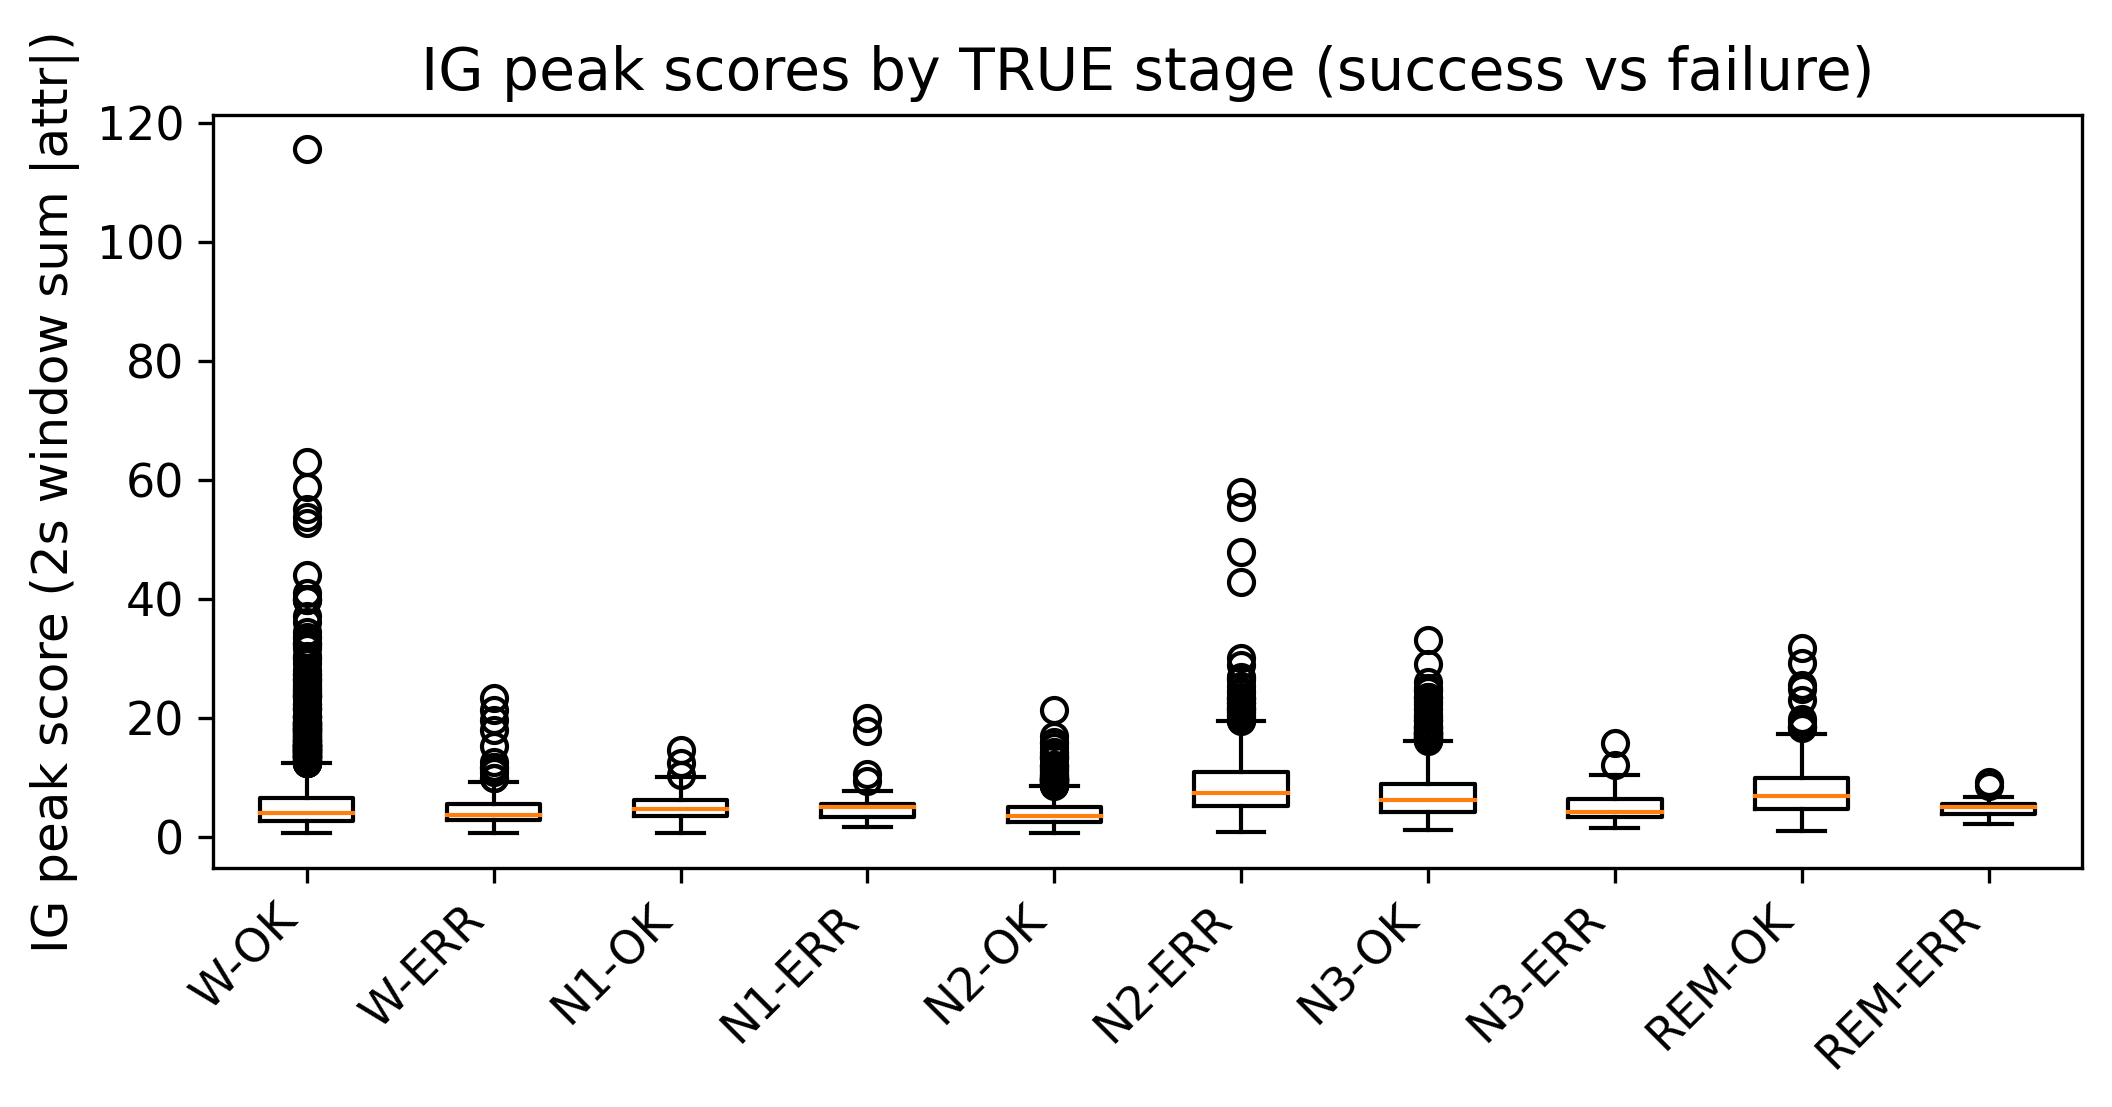

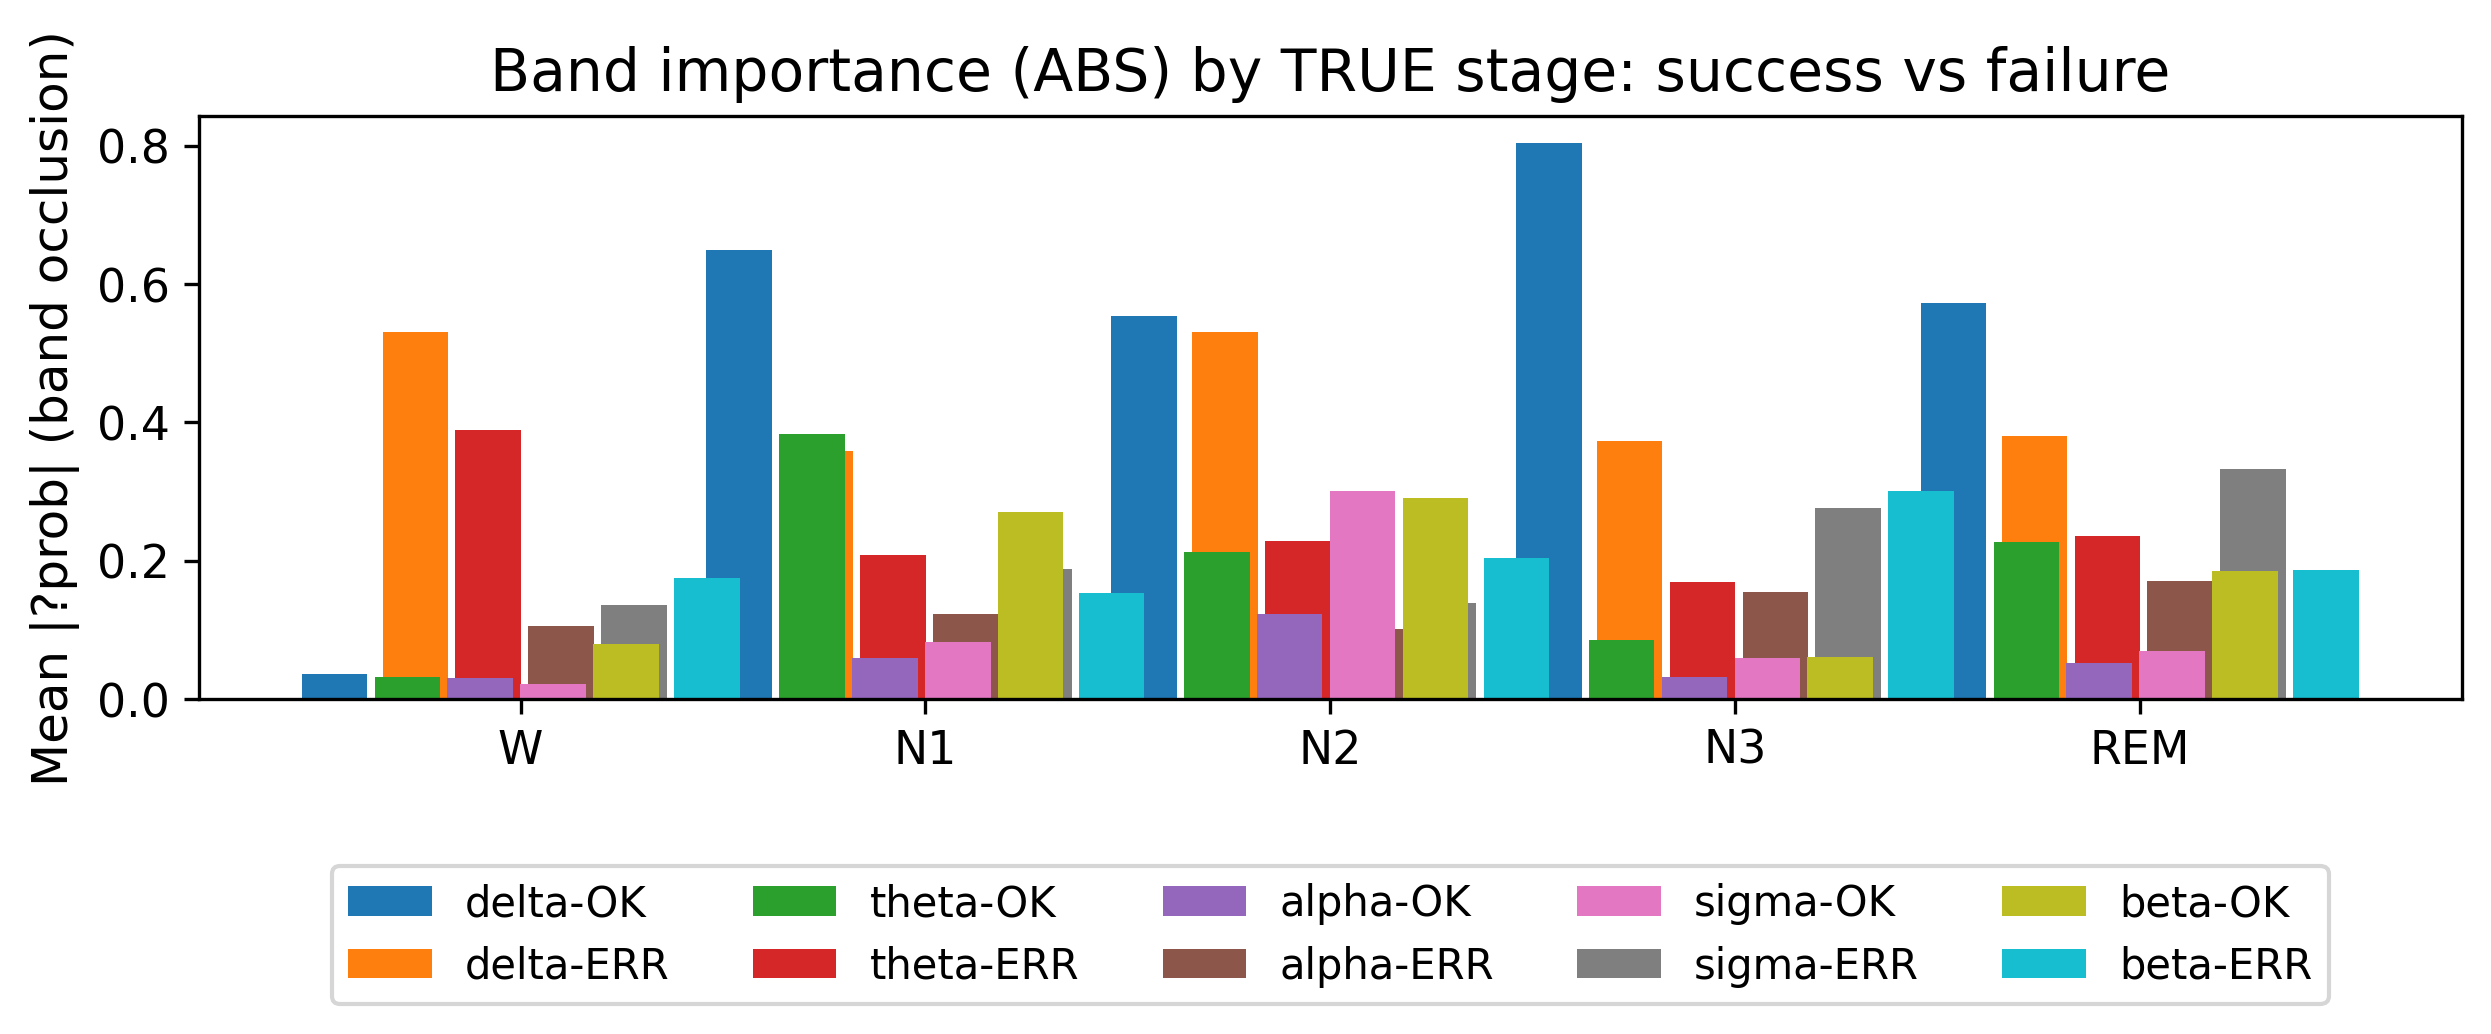

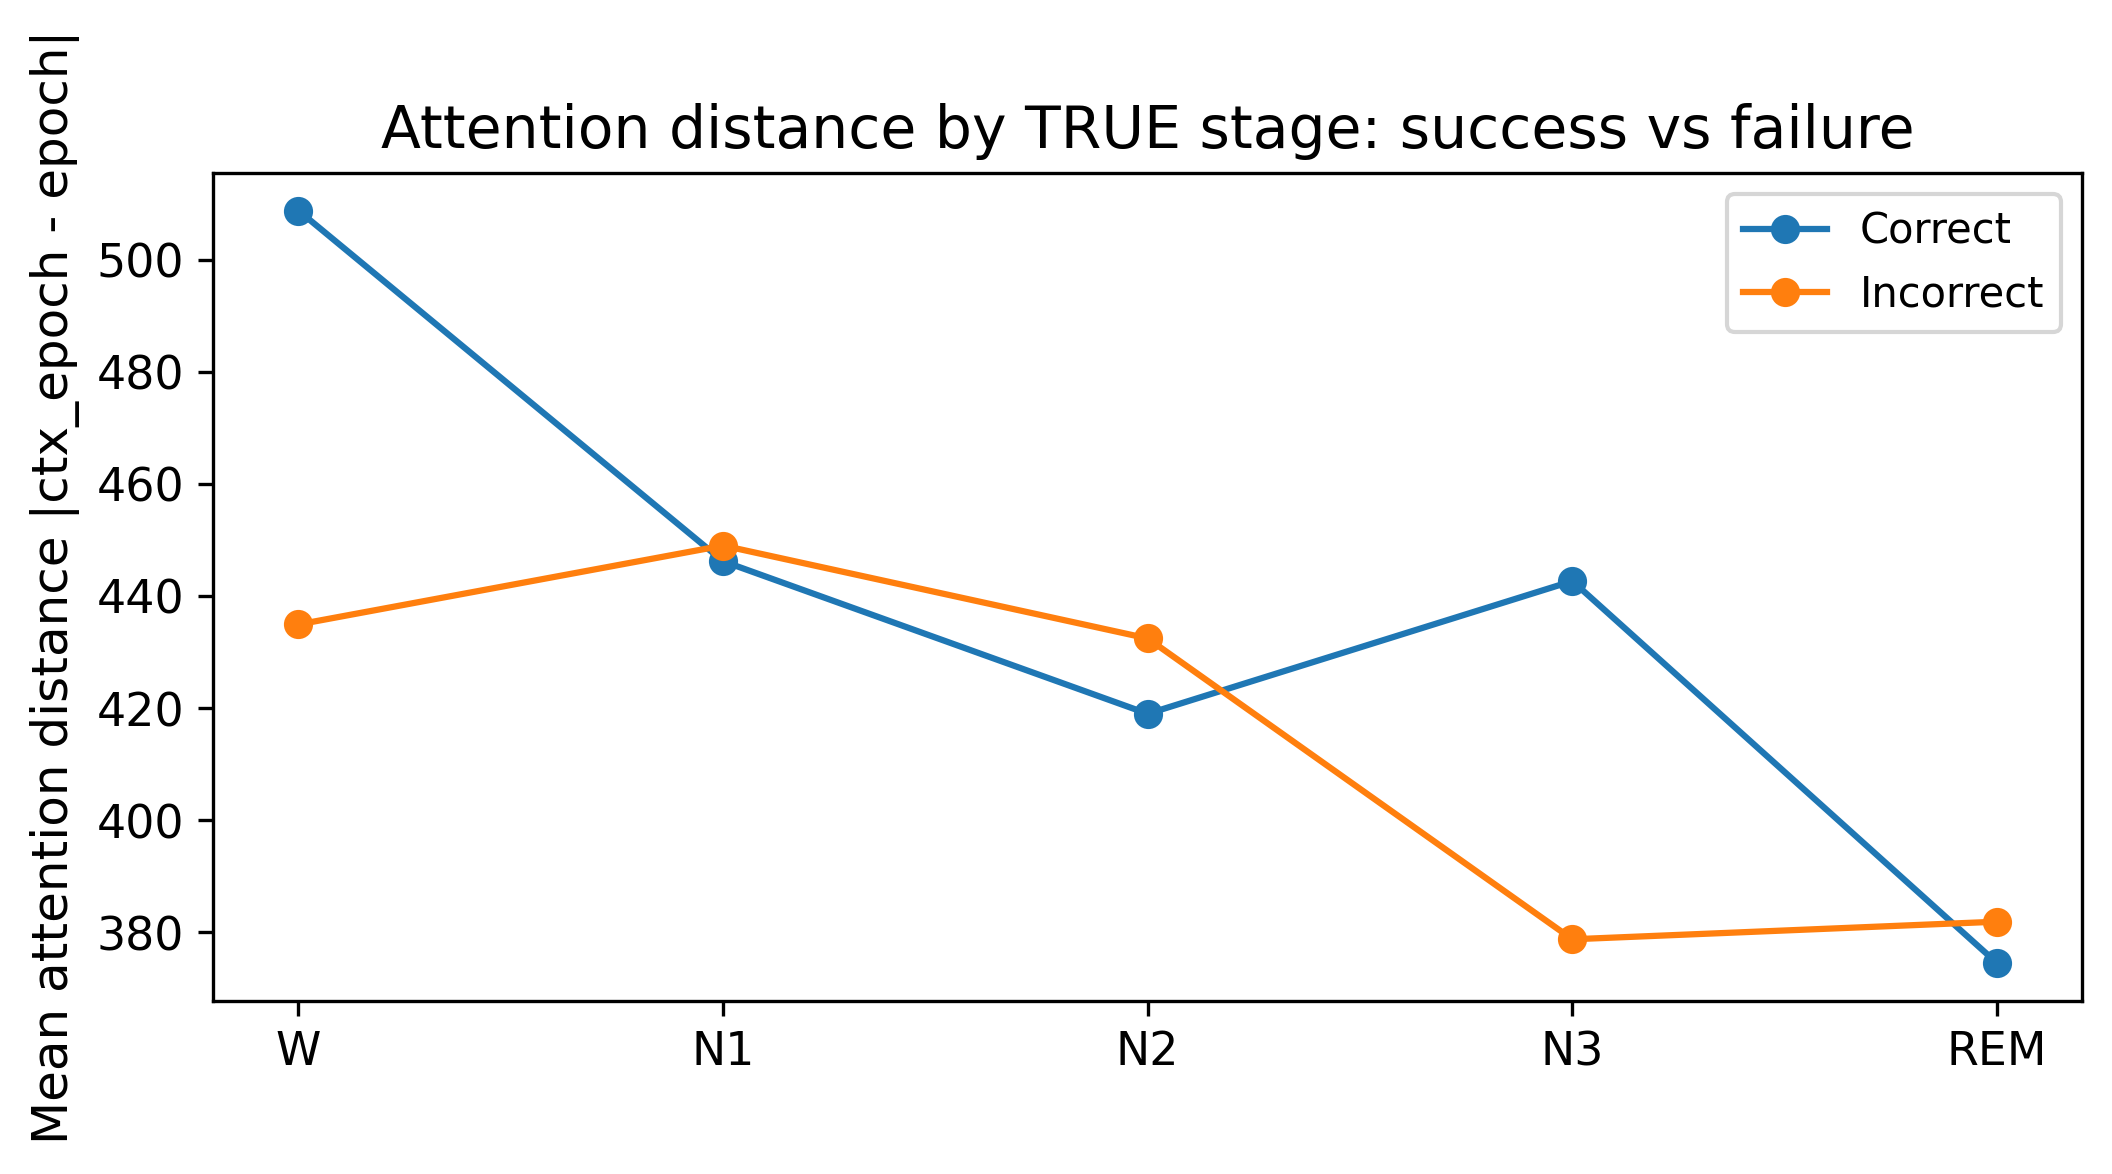

Saved figures to: runs_interpretability_shhs1/20260110_013004/paper_analysis


In [57]:
# %%
import matplotlib as mpl
import matplotlib.pyplot as plt

DPI = 300
mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.family": "DejaVu Sans",   # use DejaVu to avoid Times missing on many servers
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

OUT_DIR = RUN_DIR / "paper_analysis"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save CSVs
df_use.to_csv(OUT_DIR / "df_use.csv", index=False)
band_tbl_raw.to_csv(OUT_DIR / "band_tbl_raw.csv", index=False)
band_tbl_abs.to_csv(OUT_DIR / "band_tbl_abs.csv", index=False)
cm.to_csv(OUT_DIR / "cm_row_normalized.csv")
cm_counts.to_csv(OUT_DIR / "cm_counts.csv")

print("Saved CSVs to:", OUT_DIR)

# --- Plot 1: IG distribution, split by correct
fig = plt.figure(figsize=(7.2, 3.8))
data = []
labels = []
for s in STAGES:
    data.append(df_use[(df_use.true_stage==s) & (df_use.correct==True)]["ig_peak_score"].dropna().values)
    labels.append(f"{s}-OK")
    data.append(df_use[(df_use.true_stage==s) & (df_use.correct==False)]["ig_peak_score"].dropna().values)
    labels.append(f"{s}-ERR")

plt.boxplot(data, labels=labels, showfliers=True)
plt.ylabel("IG peak score (2s window sum |attr|)")
plt.title("IG peak scores by TRUE stage (success vs failure)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_ig_success_failure.png", bbox_inches="tight")
plt.savefig(OUT_DIR / "fig_ig_success_failure.pdf", bbox_inches="tight")
plt.show()

# --- Plot 2: Band ABS importance mean per stage × correct (grouped bars)
band_abs_mean = (
    df_long.groupby(["true_stage","correct","band"])["abs_drop"]
    .mean().reset_index()
)

# build matrix per (stage,correct) with columns bands
def pivot_band(correct_flag: bool):
    p = band_abs_mean[band_abs_mean["correct"]==correct_flag].pivot(index="true_stage", columns="band", values="abs_drop")
    return p.reindex(STAGES)[BANDS].fillna(0.0)

P_ok  = pivot_band(True).values
P_err = pivot_band(False).values

x = np.arange(len(STAGES))
width = 0.18

fig = plt.figure(figsize=(8.5, 3.8))
# plot OK and ERR as separate groups per band (slightly offset)
for j, band in enumerate(BANDS):
    plt.bar(x + (j-2)*width - 0.10, P_ok[:, j],  width*0.9, label=f"{band}-OK")
    plt.bar(x + (j-2)*width + 0.10, P_err[:, j], width*0.9, label=f"{band}-ERR")

plt.xticks(x, STAGES)
plt.ylabel("Mean |?prob| (band occlusion)")
plt.title("Band importance (ABS) by TRUE stage: success vs failure")
plt.legend(ncol=5, bbox_to_anchor=(0.5, -0.25), loc="upper center")
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_band_abs_success_failure.png", bbox_inches="tight")
plt.savefig(OUT_DIR / "fig_band_abs_success_failure.pdf", bbox_inches="tight")
plt.show()

# --- Plot 3: Attention mean distance by stage × correct
fig = plt.figure(figsize=(7.2, 3.6))
means_ok  = [df_use[(df_use.true_stage==s)&(df_use.correct==True)]["attn_mean_dist"].mean() for s in STAGES]
means_err = [df_use[(df_use.true_stage==s)&(df_use.correct==False)]["attn_mean_dist"].mean() for s in STAGES]

plt.plot(STAGES, means_ok, marker="o", label="Correct")
plt.plot(STAGES, means_err, marker="o", label="Incorrect")
plt.ylabel("Mean attention distance |ctx_epoch - epoch|")
plt.title("Attention distance by TRUE stage: success vs failure")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "fig_attn_distance_success_failure.png", bbox_inches="tight")
plt.savefig(OUT_DIR / "fig_attn_distance_success_failure.pdf", bbox_inches="tight")
plt.show()

print("Saved figures to:", OUT_DIR)
